In [163]:
# 사전에 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import MultipleLocator
import ast
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
from sklearn.linear_model import LogisticRegression

# 시드 설정
random.seed(42)

# 모든 컬럼 보이도록 하는 속성코드
pd.set_option('display.max_columns', None)

# Data 전처리 및 파생변수 생성

- 여러 번의 실험을 진행하였음
    - 1차적으로는 모든 연속형 변수를 PCA하여 2차원 변수로 합친 후, 결과를 확인하였음.
    - 그 결과, `Price`, `Delivery_dalay_time`, `total_delivery_time`, `Monetary` 4가지 변수가 영향력이 가장 큰 변수로 확인이 되어, 4가지 변수로 다시 PCA 진행함.

## customers

**`customers.csv` [파일]**
- 고객과 관련된 정보
- Customer_id : 고객 ID (주문 관련 식별자 - 고객이 동일하더라도 주문 건마다 서로 다른 Customer_id를 가질 수 있음)
- Customer_unique_id : 고객 고유 ID (고객 개별적 존재 식별자: 동일 고객이 여러 번 주문하더라도 Customer_unique_id는 변하지 않음)
- Customer_zipcode_prefix : 고객 우편번호 앞부분
- Customer_city : 고객 도시
- Customer_state : 고객 주

In [2]:
# 데이터 임포트
customers = pd.read_csv('data/customers.csv')

In [3]:
# 필요없는 columns drop
customers.drop(columns=['Customer_zipcode_prefix', 'Customer_state'], inplace=True)

In [4]:
# null값 확인
customers.isnull().sum()

Customer_id           0
Customer_unique_id    0
Customer_city         0
dtype: int64

In [5]:
# 데이터 확인
customers.head()

,Customer_id,Customer_unique_id,Customer_city
0,CUSTOMER_00000,CUSTOMER_Unique_00000,franca
1,CUSTOMER_00001,CUSTOMER_Unique_00001,sao bernardo do campo
2,CUSTOMER_00002,CUSTOMER_Unique_00002,sao paulo
3,CUSTOMER_00003,CUSTOMER_Unique_00003,mogi das cruzes
4,CUSTOMER_00004,CUSTOMER_Unique_00004,jaragua do sul


- `Customer_unique_id`의 각 값(고객 고유 ID)이 몇 번 나타나는지를 계산합니다. 이를 통해 각 고객의 구매 횟수를 알 수 있습니다. (RFM의 F단계)

In [7]:
# 고객 별 구매횟수
customers_count = customers['Customer_unique_id'].value_counts().to_frame().reset_index()

customers_count

,Customer_unique_id,count
0,CUSTOMER_Unique_12500,12
1,CUSTOMER_Unique_04511,9
2,CUSTOMER_Unique_14867,7
3,CUSTOMER_Unique_23151,7
4,CUSTOMER_Unique_06180,7
...,...,...
85107,CUSTOMER_Unique_29211,1
85108,CUSTOMER_Unique_29210,1
85109,CUSTOMER_Unique_29209,1
85110,CUSTOMER_Unique_29208,1


In [ ]:
# 고객 별 구매 횟수 확인
customers_count['count'].value_counts()

count
1     82554
2      2353
3       164
4        23
5         9
6         4
7         3
12        1
9         1
Name: count, dtype: int64

- 전체 고유 고객: 85112명
    - 1번만 구매한 고객: 82554명
    - 2번 이상 구매한 고객: 2558명

### 타깃 파생 변수 생성 (이진 변수)
- `Purchase_frequency_binary`
    - 1번 이하 구매한 고객은 0
    - 2번 이상 구매한 고객은 1

In [8]:
customers_count.columns = ['Customer_unique_id', 'count']

# 파생변수 생성: 구매 횟수가 1이하면 0, 2 이상이면 1
customers_count['Purchase_frequency_binary'] = customers_count['count'].apply(lambda x: 0 if x <= 1 else 1)

# 원래 'customers' 데이터프레임에 새로운 변수 병합 (Customer_unique_id 기준)
customers = pd.merge(customers, customers_count[['Customer_unique_id', 'count', 'Purchase_frequency_binary']], 
                     on='Customer_unique_id', how='left')

customers.head()

,Customer_id,Customer_unique_id,Customer_city,count,Purchase_frequency_binary
0,CUSTOMER_00000,CUSTOMER_Unique_00000,franca,1,0
1,CUSTOMER_00001,CUSTOMER_Unique_00001,sao bernardo do campo,1,0
2,CUSTOMER_00002,CUSTOMER_Unique_00002,sao paulo,1,0
3,CUSTOMER_00003,CUSTOMER_Unique_00003,mogi das cruzes,1,0
4,CUSTOMER_00004,CUSTOMER_Unique_00004,jaragua do sul,2,1


### Customer 데이터 EDA 시각화

Purchase_frequency_binary 빈도 시각화

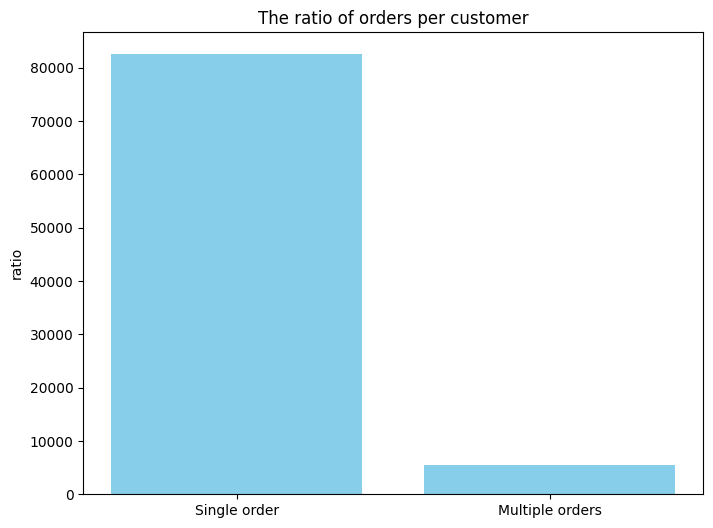

In [12]:
# 전체 고객 수 계산
total_customers = len(customers)

# 1번 주문한 고객과 2번 이상 주문한 고객 비율 계산
x = ["Single order", 'Multiple orders']
y = [
    len(customers[customers['Purchase_frequency_binary'] == 0]),
    len(customers[customers['Purchase_frequency_binary'] == 1])
]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(x, y, color='skyblue')
plt.title('The ratio of orders per customer')
plt.ylabel('ratio')
plt.show()

지역 별 구매 횟수

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/1272428895.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Customer_city', data=data,


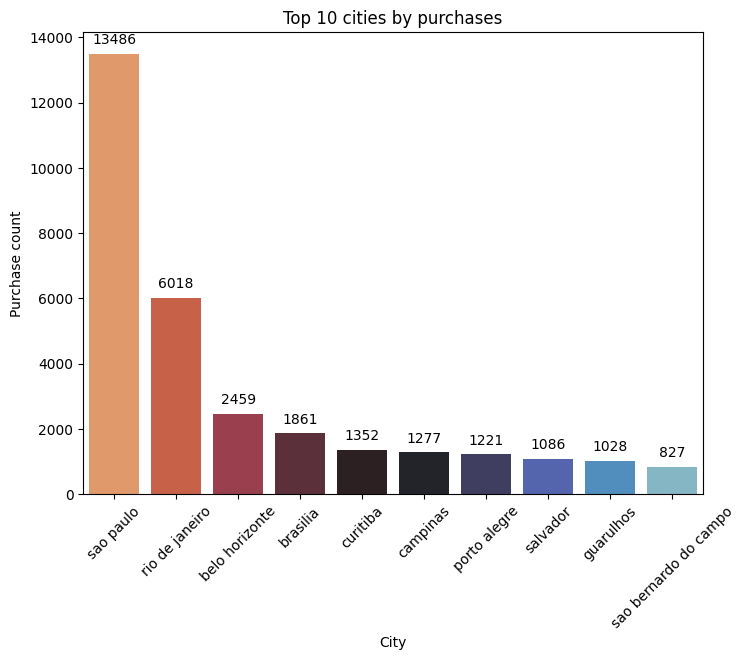

In [13]:
# 상위 10개 도시 선택
top10_cities = customers['Customer_city'].value_counts().head(10).index

# 상위 10개 도시에 대한 데이터만 필터링
data = customers[customers['Customer_city'].isin(top10_cities)]

# 시각화
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Customer_city', data=data,
                   order=data['Customer_city'].value_counts().index,
                   palette='icefire_r')

plt.title('Top 10 cities by purchases')
plt.xticks(rotation=45) # 도시 이름이 긴 경우를 위해 x축 라벨 회전
plt.xlabel('City')
plt.ylabel('Purchase count')

# 각 바 위에 값 표시
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

## locations

`locations.csv` [파일]
- 지역과 관련된 정보
- Geolocation_zipcode_prefix : 우편번호 앞부분
- Geolocation_lat : 위도
- Geolocation_lng : 경도
- Geolocation_city : 도시(city)
- Geolocation_state : 주(state)

In [14]:
locations = pd.read_csv('data/locations.csv')

In [15]:
# 필요없는 컬럼 drop
locations.drop(columns=['Geolocation_zipcode_prefix', 'Geolocation_state'], inplace=True)

In [16]:
# null값 확인
locations.isnull().sum()

Geolocation_lat     0
Geolocation_lng     0
Geolocation_city    0
dtype: int64

## order_items

**`order_items.csv` [파일]**
- 주문 아이템과 관련된 정보
- Order_id : 주문 고유 ID
- Order_item_id : 동일한 주문에 포함된 품목 수를 식별하는 일련 번호
- Product_id : 제품 고유 ID
- Seller_id : 판매자 고유 ID
- Price : 판매 가격
- Freight_value : 품목 화물 가격

In [ ]:
# 데이터 로드
order_items = pd.read_csv('data/order_items.csv')

In [20]:
# 동일한 주문에 포함된 품목 갯수 확인
order_items['Order_item_id'].value_counts()

Order_item_id
1     87954
2      8857
3      2063
4       860
5       400
6       222
7        53
8        34
9        26
10       23
11       16
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

In [21]:
# null 값 확인
order_items.isnull().sum()

Order_id         0
Order_item_id    0
Product_id       0
Seller_id        0
Price            0
Freight_value    0
dtype: int64

In [22]:
order_items.head()

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value
0,ORDER_75477,1,PRODUCT_23128,SELLER_0452,58.9,13.29
1,ORDER_63604,1,PRODUCT_24351,SELLER_0414,239.9,19.93
2,ORDER_05566,1,PRODUCT_20226,SELLER_1637,199.0,17.87
3,ORDER_04632,1,PRODUCT_07878,SELLER_1445,199.9,18.14
4,ORDER_61452,1,PRODUCT_03505,SELLER_0581,21.9,12.69


데이터 정리
- 한 Order_id에 있는 모든 Product_id, Seller_id 하나의 row로 정리
    - 각 Order_id 별 Product의 Price, Freight_value의 총합으로 산출
    - 함께 구매한 제품 갯수 산출

In [23]:
# 같은 order를 가지는 행의 price,Freight_value 는 모두 합하고 product_id는 unique한 값들을 리스트로 저장
order_items = order_items.groupby('Order_id').agg({
    'Price': 'sum', 
    'Product_id': lambda x: list(x), 
    'Seller_id': lambda x: list(x),
    'Freight_value': 'sum'
}).reset_index()


# product_id가 여러개인 경우, product_id 개수 저장
order_items['Product_count'] = order_items['Product_id'].apply(lambda x: len(x))
order_items = order_items.sort_values('Product_count', ascending=False)

order_items.head()

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count
78559,ORDER_78678,31.80,"[PRODUCT_02443, PRODUCT_14477, PRODUCT_14477, ...","[SELLER_2467, SELLER_2467, SELLER_2467, SELLER...",164.37,21
76911,ORDER_77030,2000.00,"[PRODUCT_24966, PRODUCT_24966, PRODUCT_24966, ...","[SELLER_0262, SELLER_0262, SELLER_0262, SELLER...",202.40,20
83156,ORDER_83280,1974.00,"[PRODUCT_22941, PRODUCT_22941, PRODUCT_22941, ...","[SELLER_1627, SELLER_1627, SELLER_1627, SELLER...",288.80,20
58686,ORDER_58777,765.00,"[PRODUCT_14642, PRODUCT_14642, PRODUCT_14642, ...","[SELLER_2683, SELLER_2683, SELLER_2683, SELLER...",18.00,15
26791,ORDER_26840,982.35,"[PRODUCT_18605, PRODUCT_18605, PRODUCT_18605, ...","[SELLER_0406, SELLER_0406, SELLER_0406, SELLER...",243.30,15


In [24]:
# 중복 확인
order_items[order_items['Order_id'].duplicated()]

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count


### order_items 데이터 EDA 시각화

Price 데이터 박스플롯 통해 분포확인

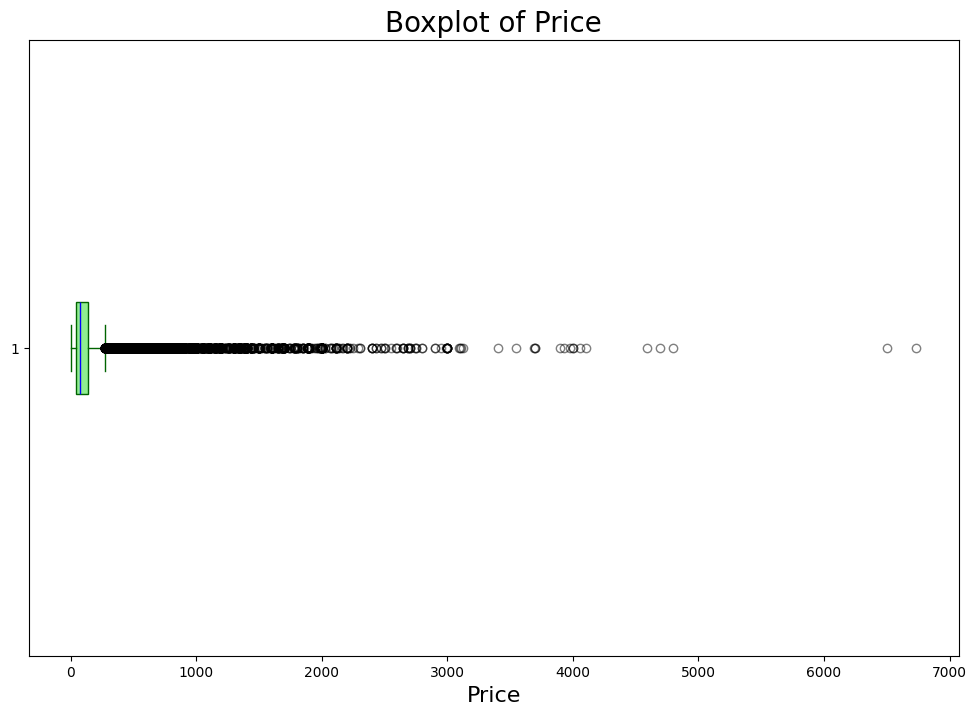

In [19]:
# 박스플롯 그리기
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# Price 데이터가 들어있다고 가정한 리스트를 사용하여 박스플롯 생성
plt.boxplot(order_items['Price'], patch_artist=True, vert=False, boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            whiskerprops=dict(color='darkgreen'), capprops=dict(color='darkgreen'), flierprops=dict(marker='o', color='red', alpha=0.5),
            medianprops=dict(color='blue'))

# 그래프 제목과 축 레이블 추가
plt.title('Boxplot of Price', fontsize=20)
plt.xlabel('Price', fontsize=16)

# 그래프 표시
plt.show()

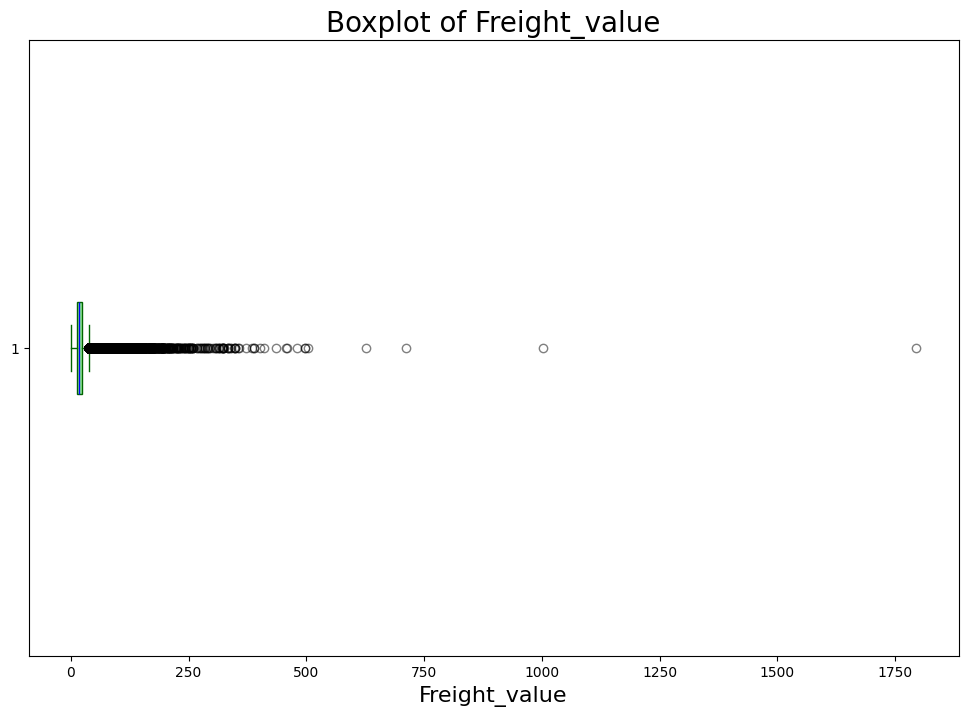

In [25]:
# 박스플롯 그리기
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# Price 데이터가 들어있다고 가정한 리스트를 사용하여 박스플롯 생성
plt.boxplot(order_items['Freight_value'], patch_artist=True, vert=False, boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            whiskerprops=dict(color='darkgreen'), capprops=dict(color='darkgreen'), flierprops=dict(marker='o', color='red', alpha=0.5),
            medianprops=dict(color='blue'))

# 그래프 제목과 축 레이블 추가
plt.title('Boxplot of Freight_value', fontsize=20)
plt.xlabel('Freight_value', fontsize=16)

# 그래프 표시
plt.show()

## orders

- `orders.csv` [파일]
    - 주문과 관련된 정보
    - Order_id : 주문 고유 ID
    - Customer_id : 고객 ID
    - Order_status : 주문 상태
    - Order_purchase_timestamp : 구매 시간
    - Order_delivered_carrier_date : 물류 처리 시간
    - Order_delivered_customer_date : 실제 배송 날짜
    - Order_estimated_delivery_date : 기대 배송 날짜

In [26]:
# 데이터 로드
orders = pd.read_csv('data/orders.csv')

In [27]:
# Order_id 중복 확인
orders[orders['Order_id'].duplicated()]

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date


In [28]:
# 날짜 데이터 타입 변환
orders['Order_delivered_customer_date'] = pd.to_datetime(orders['Order_delivered_customer_date'])
orders['Order_estimated_delivery_date'] = pd.to_datetime(orders['Order_estimated_delivery_date'])
orders['Order_purchase_timestamp'] = pd.to_datetime(orders['Order_purchase_timestamp'])
orders['Order_delivered_carrier_date'] = pd.to_datetime(orders['Order_delivered_carrier_date'])

In [ ]:
# 필요없는 column drop
orders.drop(columns='Order_status', inplace=True)

In [31]:
# null값 확인
orders.isnull().sum()

Order_id                         0
Customer_id                      0
Order_purchase_timestamp         0
Order_delivered_carrier_date     0
Order_delivered_customer_date    0
Order_estimated_delivery_date    0
dtype: int64

### 파생 변수 생성
- `Delivery_delay_time`: 실제 배송 날짜 - 기대 배송 날짜
- `total_delivery_time`: 실제 배송 날짜 - 구매 날짜
- `estimated_delivery_time`: 추정 배송 날짜 - 구매 날짜

In [33]:
# 실제 배송 날짜 - 기대 배송 날짜의 차이
orders['Delivery_delay_time'] = (orders['Order_delivered_customer_date'] - orders['Order_estimated_delivery_date']).dt.days
# 실제 배송 날짜 - 구매 날짜의 차이
orders['total_delivery_time'] = (orders['Order_delivered_customer_date'] - orders['Order_purchase_timestamp']).dt.days

# 추정 배송 날짜 - 구매 날짜의 차이
orders['estimated_delivery_time'] = (orders['Order_estimated_delivery_date'] - orders['Order_purchase_timestamp']).dt.days

In [34]:
orders.head()

,Order_id,Customer_id,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Delivery_delay_time,total_delivery_time,estimated_delivery_time
0,ORDER_00000,CUSTOMER_62232,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,-8,8,15
1,ORDER_00001,CUSTOMER_54059,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,-13,13,26
2,ORDER_00002,CUSTOMER_59535,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,-10,2,12
3,ORDER_00003,CUSTOMER_60516,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01,-6,16,22
4,ORDER_00004,CUSTOMER_76957,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07,-12,9,21


## payment
- `payments.csv` [파일]
    - 지불과 관련된 정보
    - Order_id : 주문 고유 ID
    - Payment_sequential : 결제 시퀀스(둘 이상의 결제 방법으로 결제 가능)
    - Payment_type : 지불 방법 
    - Payment_installments : 할부 횟수
    - Payment_value : 거래 가치

In [ ]:
# 데이터 로드
payments = pd.read_csv('data/payments.csv')

In [37]:
payments.head()

,Order_id,Payment_sequential,Payment_type,Payment_installments,Payment_value
0,ORDER_66617,1,credit_card,8,99.33
1,ORDER_86954,1,credit_card,1,24.39
2,ORDER_38852,1,credit_card,1,65.71
3,ORDER_57443,1,credit_card,8,107.78
4,ORDER_11244,1,credit_card,2,128.45


In [38]:
# Null값 확인
payments.isnull().sum()

Order_id                0
Payment_sequential      0
Payment_type            0
Payment_installments    0
Payment_value           0
dtype: int64

### 파생 변수 생성
- 각 지불 방법 카테고리 별, 지불 금액 산출

In [39]:
# 지불 방법 별 금액 총합
payments_2 = payments.groupby(['Order_id','Payment_type'])['Payment_value'].sum().unstack(fill_value=0).reset_index()
payments_2 = payments.groupby(['Order_id','Payment_type'])['Payment_value'].sum().unstack(fill_value=0).reset_index()
payments_2.rename(columns={'boleto': 'sum_boleto'}, inplace=True)
payments_2.rename(columns={'credit_card': 'sum_credit_card'}, inplace=True)
payments_2.rename(columns={'debit_card': 'sum_debit_card'}, inplace=True)
payments_2.rename(columns={'voucher': 'sum_voucher'}, inplace=True)

In [40]:
payments_2.head()

Payment_type,Order_id,sum_boleto,sum_credit_card,sum_debit_card,sum_voucher
0,ORDER_00000,0.0,18.12,0.0,20.59
1,ORDER_00001,0.0,72.20,0.0,0.00
2,ORDER_00002,0.0,28.62,0.0,0.00
3,ORDER_00003,0.0,175.26,0.0,0.00
4,ORDER_00004,0.0,75.16,0.0,0.00


In [41]:
# 기존 데이터와 Order_id 기준으로 병합
payments = pd.merge(payments, payments_2, on = 'Order_id', how = 'left')

In [42]:
# 필요없는 컬럼 Drop
payments = payments.drop(columns=['Payment_sequential'])

In [44]:
payments.head()

,Order_id,Payment_type,Payment_installments,Payment_value,sum_boleto,sum_credit_card,sum_debit_card,sum_voucher
0,ORDER_66617,credit_card,8,99.33,0.0,99.33,0.0,0.0
1,ORDER_86954,credit_card,1,24.39,0.0,24.39,0.0,0.0
2,ORDER_38852,credit_card,1,65.71,0.0,65.71,0.0,0.0
3,ORDER_57443,credit_card,8,107.78,0.0,107.78,0.0,0.0
4,ORDER_11244,credit_card,2,128.45,0.0,128.45,0.0,0.0


데이터 정리
- Order_id 기준으로 한 row로 데이터 정리

In [45]:
# 같은 Order_id 기준으로 Payment_type, Payment_value, Payment_installments 처리
payments = payments.groupby('Order_id').agg({
    'Payment_type': list,
    'Payment_value': 'sum',
    'Payment_installments': 'max',
    'sum_credit_card': 'mean',
    'sum_boleto': 'mean',
    'sum_debit_card': 'mean',
    'sum_voucher': 'mean'
}).reset_index()

In [46]:
payments.head()

,Order_id,Payment_type,Payment_value,Payment_installments,sum_credit_card,sum_boleto,sum_debit_card,sum_voucher
0,ORDER_00000,"[credit_card, voucher, voucher]",38.71,1,18.12,0.0,0.0,20.59
1,ORDER_00001,[credit_card],72.20,1,72.20,0.0,0.0,0.00
2,ORDER_00002,[credit_card],28.62,1,28.62,0.0,0.0,0.00
3,ORDER_00003,[credit_card],175.26,6,175.26,0.0,0.0,0.00
4,ORDER_00004,[credit_card],75.16,3,75.16,0.0,0.0,0.00


### Payment 데이터 EDA 시각화

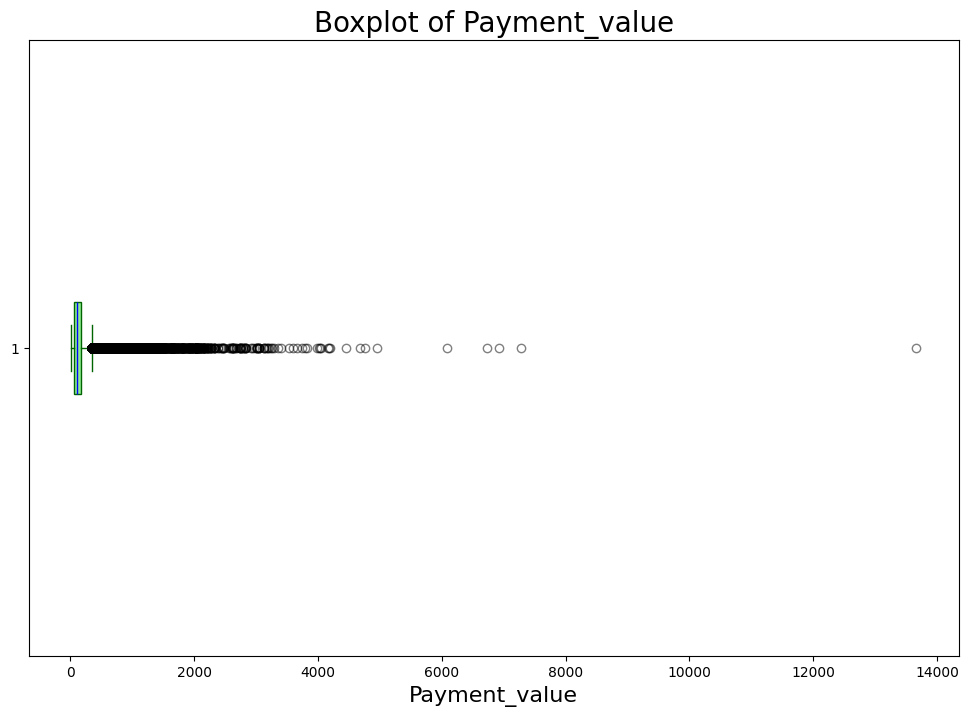

In [47]:
# 박스플롯 그리기
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# Price 데이터가 들어있다고 가정한 리스트를 사용하여 박스플롯 생성
plt.boxplot(payments['Payment_value'], patch_artist=True, vert=False, boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            whiskerprops=dict(color='darkgreen'), capprops=dict(color='darkgreen'), flierprops=dict(marker='o', color='red', alpha=0.5),
            medianprops=dict(color='blue'))

# 그래프 제목과 축 레이블 추가
plt.title('Boxplot of Payment_value', fontsize=20)
plt.xlabel('Payment_value', fontsize=16)

# 그래프 표시
plt.show()

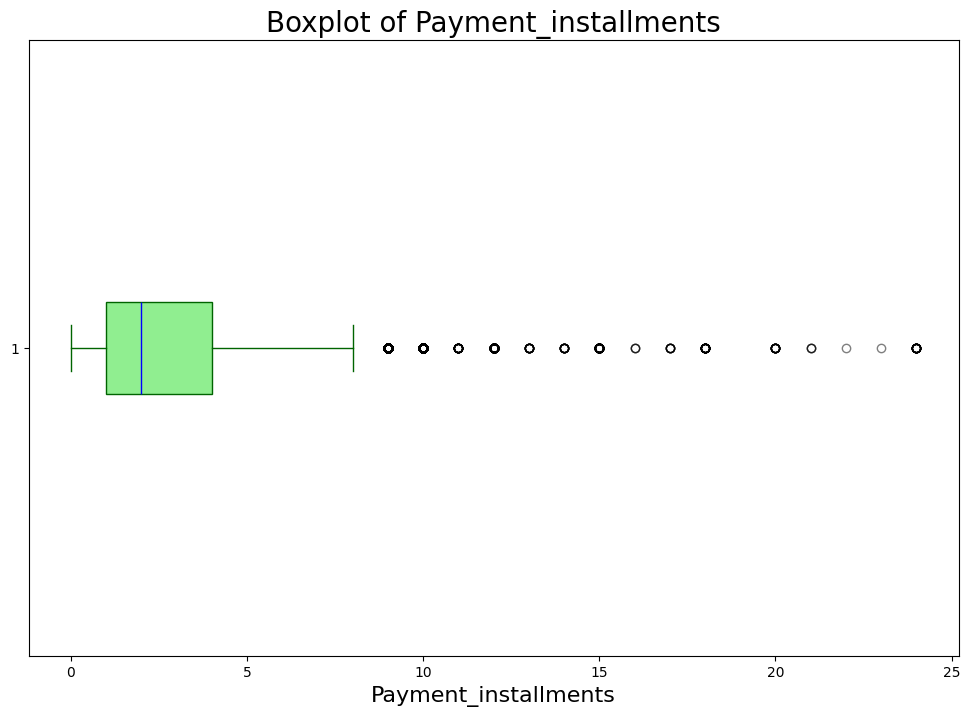

In [48]:
# 박스플롯 그리기
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# Price 데이터가 들어있다고 가정한 리스트를 사용하여 박스플롯 생성
plt.boxplot(payments['Payment_installments'], patch_artist=True, vert=False, boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            whiskerprops=dict(color='darkgreen'), capprops=dict(color='darkgreen'), flierprops=dict(marker='o', color='red', alpha=0.5),
            medianprops=dict(color='blue'))

# 그래프 제목과 축 레이블 추가
plt.title('Boxplot of Payment_installments', fontsize=20)
plt.xlabel('Payment_installments', fontsize=16)

# 그래프 표시
plt.show()

## product

-   `products.csv` [파일]
    - 제품과 관련된 정보
    - Product_id : 제품 고유 ID (O)
    - Product_category_name : 카테고리 이름 (O)
    - Product_weight_g : 제품 무게(g)
    - Product_length_cm : 제품 길이(cm)
    - Product_height_cm : 제품 높이(cm)
    - Product_width_cm : 제품 너비(cm)

In [49]:
# 데이터 로드
product = pd.read_csv('data/products.csv')

In [50]:
# 필요없는 컬럼 drop
product.drop(columns=['Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm'], inplace=True)

In [51]:
# null값 확인
product.isnull().sum()

Product_id               0
Product_category_name    0
dtype: int64

In [52]:
product.head()

,Product_id,Product_category_name
0,PRODUCT_00000,perfumery
1,PRODUCT_00001,arts
2,PRODUCT_00002,sports_leisure
3,PRODUCT_00003,home_utilities
4,PRODUCT_00004,musical_instruments


- Order_items 데이터에 조인하는 작업
    - Category를 병합하기 위함

In [53]:
# Product_id에 대해 list 풀기
order_items_df_exploded = order_items.explode("Product_id")

# 데이터 병합
order_items = pd.merge(
    order_items_df_exploded,
    product,
    on="Product_id",
    how="left"
)

# 다시 이전 상황과 같이 list로 변환하기
order_items = order_items.groupby("Order_id").agg({
    "Price": "first",
    "Product_id": lambda x: list(x),
    "Seller_id": "first",
    "Freight_value": "first",
    "Product_count": "first",
    "Product_category_name": lambda x: list(x)
}).reset_index()

In [54]:
order_items.head()

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count,Product_category_name
0,ORDER_00000,29.99,[PRODUCT_02093],[SELLER_0491],8.72,1,[home_utilities]
1,ORDER_00001,45.00,[PRODUCT_26747],[SELLER_2662],27.20,1,[pet_shop]
2,ORDER_00002,19.90,[PRODUCT_10598],[SELLER_1354],8.72,1,[stationery]
3,ORDER_00003,147.90,[PRODUCT_16703],[SELLER_1518],27.36,1,[automotive]
4,ORDER_00004,59.99,[PRODUCT_08274],[SELLER_1599],15.17,1,[automotive]


## reviews

- `reviews.csv`[파일]
    - Review_id : 리뷰 고유 ID
    - Order_id : 주문 고유 ID
    - Review_score : 리뷰 점수
    - Review_creation_date : 리뷰 생성 시간
    - Review_answer_timestamp : 리뷰 답변 시간

In [55]:
# 데이터 로드
reviews = pd.read_csv('data/reviews.csv')

In [56]:
# Null값 확인
reviews.isnull().sum()

Review_id                  0
Order_id                   0
Review_score               0
Review_creation_date       0
Review_answer_timestamp    0
dtype: int64

In [57]:
# 같은 order에 대한 여러 건의 리뷰가 있는지 확인
print(reviews['Order_id'].value_counts().value_counts())

count
1    86829
2      516
3        4
Name: count, dtype: int64


In [58]:
reviews.head()

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp
0,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59
1,REVIEW_00001,ORDER_80140,5,2019-03-10 00:00:00,2019-03-11 03:05:13
2,REVIEW_00002,ORDER_69816,5,2019-02-17 00:00:00,2019-02-18 14:36:24
3,REVIEW_00003,ORDER_24398,5,2018-04-21 00:00:00,2018-04-21 22:02:06
4,REVIEW_00004,ORDER_70366,5,2019-03-01 00:00:00,2019-03-02 10:26:53


In [59]:
# 데이터 타입 변환
reviews['Review_creation_date'] = pd.to_datetime(reviews['Review_creation_date'])  # 날짜 형식 변환

# 가장 빠른 Review_creation_date의 인덱스를 찾고 데이터 필터링
reviews = reviews.loc[reviews.groupby('Order_id')['Review_creation_date'].idxmin()]

In [60]:
# 중복 없음을 확인
reviews[reviews['Order_id'].duplicated()]

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp


### Review 분포 시각화

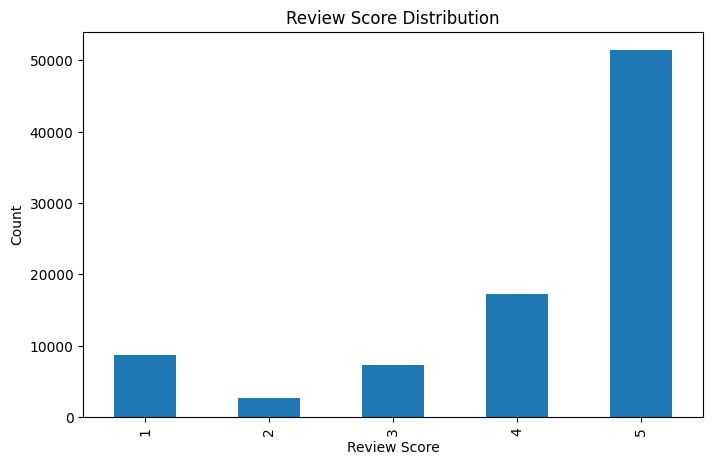

In [73]:
reviews['Review_score'].value_counts().sort_index().plot(kind='bar', figsize=(8, 5), title='Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

## Data Merge

In [61]:
# 사용할 데이터 통합하기 (필요한 데이터만)
merged_df = pd.merge(order_items, orders, on='Order_id', how='inner')
merged_df = pd.merge(merged_df, payments, on='Order_id', how='inner')
merged_df = pd.merge(merged_df, reviews, on='Order_id', how='inner')
merged_df = pd.merge(merged_df, customers, on='Customer_id', how='inner')

In [62]:
# 사용하는 컬럼 확인
merged_df.columns

Index(['Order_id', 'Price', 'Product_id', 'Seller_id', 'Freight_value',
       'Product_count', 'Product_category_name', 'Customer_id',
       'Order_purchase_timestamp', 'Order_delivered_carrier_date',
       'Order_delivered_customer_date', 'Order_estimated_delivery_date',
       'Delivery_delay_time', 'total_delivery_time', 'estimated_delivery_time',
       'Payment_type', 'Payment_value', 'Payment_installments',
       'sum_credit_card', 'sum_boleto', 'sum_debit_card', 'sum_voucher',
       'Review_id', 'Review_score', 'Review_creation_date',
       'Review_answer_timestamp', 'Customer_unique_id', 'Customer_city',
       'count', 'Purchase_frequency_binary'],
      dtype='object')

In [63]:
# 날짜/시간 형식으로 변환
merged_df['Order_purchase_timestamp'] = pd.to_datetime(merged_df['Order_purchase_timestamp'])
merged_df['Order_delivered_customer_date'] = pd.to_datetime(merged_df['Order_delivered_customer_date'])
merged_df['Order_estimated_delivery_date'] = pd.to_datetime(merged_df['Order_estimated_delivery_date'])

## RFM 구분

### R
-  `(전체기준) 마지막 구입 날짜` - `(고객마다) 마지막 구입 날짜`
- `실제 배송 날짜` - `구매 배송 날짜`

In [64]:
# 가장 최근에 거래한 날짜 추출
R_df = merged_df.groupby(by='Customer_id', as_index=False)['Order_purchase_timestamp'].max()

In [65]:
# 마지막 구입한 날짜를 의미하는 Last_purchase로 컬럼명 수정
R_df.rename(columns={'Order_purchase_timestamp':'Last_purchase'}, inplace=True)

# 각 customer_id 마다의 마지막 구입 날짜를 datetime 형태로 변환
R_df['Last_purchase'] = R_df['Last_purchase'].dt.date 

# 주어진 데이터에서 가장 최근까지 거래된 날짜와 customer_id별 마지막 거래 날짜의 차를 측정
recent_date = R_df['Last_purchase'].max()

In [66]:
# 가장 최근까지 거래된 날짜 - 고객별 마지막 거래날짜 (일자 출력)
R_df['Recency'] = R_df['Last_purchase'].apply(lambda x: (recent_date - x).days)

# 가장 마지막 구매 날짜는 필요 없으니 제거
R_df.drop('Last_purchase', axis=1, inplace=True)

R_df.head()

,Customer_id,Recency
0,CUSTOMER_00000,440
1,CUSTOMER_00001,199
2,CUSTOMER_00002,72
3,CUSTOMER_00003,139
4,CUSTOMER_00004,319


In [69]:
# 데이터 합치기
merged_df = pd.merge(merged_df, R_df, on='Customer_id', how='left')

### F
- `물건 구입 횟수` Count
    - 이미 구해졌으므로 Column명만 변경

In [67]:
# 물건의 구입 횟수를 의미하는 frequency 컬럼 명으로 변경
merged_df.rename(columns={'count':'Frequency'}, inplace=True)

### M
- `얼마나 구매 했는지 (How much)`
    - 마찬가지로 이미 구해졌으므로 Column명만 변경

In [68]:
# 얼마나 구매했는가 확인 monetary 컬럼명으로 변경
merged_df.rename(columns={'Payment_value' : 'Monetary'}, inplace=True) 

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count,Product_category_name,Customer_id,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Delivery_delay_time,total_delivery_time,estimated_delivery_time,Payment_type,Monetary,Payment_installments,sum_credit_card,sum_boleto,sum_debit_card,sum_voucher,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Customer_unique_id,Customer_city,Frequency,Purchase_frequency_binary
0,ORDER_00000,29.99,[PRODUCT_02093],[SELLER_0491],8.72,1,[home_utilities],CUSTOMER_62232,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,-8,8,15,"[credit_card, voucher, voucher]",38.71,1,18.12,0.0,0.0,20.59,REVIEW_29035,4,2018-10-11,2018-10-12 03:43:48,CUSTOMER_Unique_60785,sao paulo,2,1
1,ORDER_00001,45.00,[PRODUCT_26747],[SELLER_2662],27.20,1,[pet_shop],CUSTOMER_54059,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,-13,13,26,[credit_card],72.20,1,72.20,0.0,0.0,0.00,REVIEW_68285,5,2018-12-03,2018-12-05 19:21:58,CUSTOMER_Unique_52983,sao goncalo do amarante,1,0
2,ORDER_00002,19.90,[PRODUCT_10598],[SELLER_1354],8.72,1,[stationery],CUSTOMER_59535,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,-10,2,12,[credit_card],28.62,1,28.62,0.0,0.0,0.00,REVIEW_47810,5,2019-02-17,2019-02-18 13:02:51,CUSTOMER_Unique_58227,santo andre,1,0
3,ORDER_00003,147.90,[PRODUCT_16703],[SELLER_1518],27.36,1,[automotive],CUSTOMER_60516,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01,-6,16,22,[credit_card],175.26,6,175.26,0.0,0.0,0.00,REVIEW_83209,4,2018-07-27,2018-07-27 22:48:30,CUSTOMER_Unique_59164,congonhinhas,1,0
4,ORDER_00004,59.99,[PRODUCT_08274],[SELLER_1599],15.17,1,[automotive],CUSTOMER_76957,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07,-12,9,21,[credit_card],75.16,3,75.16,0.0,0.0,0.00,REVIEW_29577,5,2018-05-27,2018-05-28 02:59:57,CUSTOMER_Unique_74753,nilopolis,1,0


In [71]:
# Null값 확인
merged_df.isnull().sum()

Order_id                         0
Price                            0
Product_id                       0
Seller_id                        0
Freight_value                    0
Product_count                    0
Product_category_name            0
Customer_id                      0
Order_purchase_timestamp         0
Order_delivered_carrier_date     0
Order_delivered_customer_date    0
Order_estimated_delivery_date    0
Delivery_delay_time              0
total_delivery_time              0
estimated_delivery_time          0
Payment_type                     0
Monetary                         0
Payment_installments             0
sum_credit_card                  0
sum_boleto                       0
sum_debit_card                   0
sum_voucher                      0
Review_id                        0
Review_score                     0
Review_creation_date             0
Review_answer_timestamp          0
Customer_unique_id               0
Customer_city                    0
Frequency           

In [72]:
merged_df.head()

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count,Product_category_name,Customer_id,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Delivery_delay_time,total_delivery_time,estimated_delivery_time,Payment_type,Monetary,Payment_installments,sum_credit_card,sum_boleto,sum_debit_card,sum_voucher,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Customer_unique_id,Customer_city,Frequency,Purchase_frequency_binary,Recency
0,ORDER_00000,29.99,[PRODUCT_02093],[SELLER_0491],8.72,1,[home_utilities],CUSTOMER_62232,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,-8,8,15,"[credit_card, voucher, voucher]",38.71,1,18.12,0.0,0.0,20.59,REVIEW_29035,4,2018-10-11,2018-10-12 03:43:48,CUSTOMER_Unique_60785,sao paulo,2,1,301
1,ORDER_00001,45.00,[PRODUCT_26747],[SELLER_2662],27.20,1,[pet_shop],CUSTOMER_54059,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,-13,13,26,[credit_card],72.20,1,72.20,0.0,0.0,0.00,REVIEW_68285,5,2018-12-03,2018-12-05 19:21:58,CUSTOMER_Unique_52983,sao goncalo do amarante,1,0,254
2,ORDER_00002,19.90,[PRODUCT_10598],[SELLER_1354],8.72,1,[stationery],CUSTOMER_59535,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,-10,2,12,[credit_card],28.62,1,28.62,0.0,0.0,0.00,REVIEW_47810,5,2019-02-17,2019-02-18 13:02:51,CUSTOMER_Unique_58227,santo andre,1,0,167
3,ORDER_00003,147.90,[PRODUCT_16703],[SELLER_1518],27.36,1,[automotive],CUSTOMER_60516,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01,-6,16,22,[credit_card],175.26,6,175.26,0.0,0.0,0.00,REVIEW_83209,4,2018-07-27,2018-07-27 22:48:30,CUSTOMER_Unique_59164,congonhinhas,1,0,386
4,ORDER_00004,59.99,[PRODUCT_08274],[SELLER_1599],15.17,1,[automotive],CUSTOMER_76957,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07,-12,9,21,[credit_card],75.16,3,75.16,0.0,0.0,0.00,REVIEW_29577,5,2018-05-27,2018-05-28 02:59:57,CUSTOMER_Unique_74753,nilopolis,1,0,440


### 데이터 저장
- csv, excel

In [ ]:
# CSV로 저장
merged_df.to_csv('merged_df.csv', index=False, encoding='utf-8-sig')
# Excel로 저장
merged_df.to_excel('merged_df.xlsx', index=False, engine='openpyxl')

# Customer Segmentation (고객 군집 분류)

- Kmeans 사용 변수
    - 모든 연속형 변수

- `KMeans` 사용을 위해 Feature 스케일링 작업
    - StandardScaler

In [74]:
# 데이터 로드
df = pd.read_csv('merged_df.csv')

In [104]:
# 문자열 형태의 리스트를 실제 리스트로 변환
df['Product_category_name'] = df['Product_category_name'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [75]:
df.head()

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count,Product_category_name,Customer_id,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Delivery_delay_time,total_delivery_time,estimated_delivery_time,Payment_type,Monetary,Payment_installments,sum_credit_card,sum_boleto,sum_debit_card,sum_voucher,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Customer_unique_id,Customer_city,Frequency,Purchase_frequency_binary,Recency
0,ORDER_00000,29.99,['PRODUCT_02093'],['SELLER_0491'],8.72,1,['home_utilities'],CUSTOMER_62232,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,-8,8,15,"['credit_card', 'voucher', 'voucher']",38.71,1,18.12,0.0,0.0,20.59,REVIEW_29035,4,2018-10-11 00:00:00,2018-10-12 03:43:48,CUSTOMER_Unique_60785,sao paulo,2,1,301
1,ORDER_00001,45.00,['PRODUCT_26747'],['SELLER_2662'],27.20,1,['pet_shop'],CUSTOMER_54059,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,-13,13,26,['credit_card'],72.20,1,72.20,0.0,0.0,0.00,REVIEW_68285,5,2018-12-03 00:00:00,2018-12-05 19:21:58,CUSTOMER_Unique_52983,sao goncalo do amarante,1,0,254
2,ORDER_00002,19.90,['PRODUCT_10598'],['SELLER_1354'],8.72,1,['stationery'],CUSTOMER_59535,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,-10,2,12,['credit_card'],28.62,1,28.62,0.0,0.0,0.00,REVIEW_47810,5,2019-02-17 00:00:00,2019-02-18 13:02:51,CUSTOMER_Unique_58227,santo andre,1,0,167
3,ORDER_00003,147.90,['PRODUCT_16703'],['SELLER_1518'],27.36,1,['automotive'],CUSTOMER_60516,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01,-6,16,22,['credit_card'],175.26,6,175.26,0.0,0.0,0.00,REVIEW_83209,4,2018-07-27 00:00:00,2018-07-27 22:48:30,CUSTOMER_Unique_59164,congonhinhas,1,0,386
4,ORDER_00004,59.99,['PRODUCT_08274'],['SELLER_1599'],15.17,1,['automotive'],CUSTOMER_76957,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07,-12,9,21,['credit_card'],75.16,3,75.16,0.0,0.0,0.00,REVIEW_29577,5,2018-05-27 00:00:00,2018-05-28 02:59:57,CUSTOMER_Unique_74753,nilopolis,1,0,440


- 여러 번의 실험을 진행하였음
    - 1차적으로는 모든 연속형 변수를 PCA하여 2차원 변수로 합친 후, 결과를 확인하였음.
    - 그 결과, `Price`, `Delivery_dalay_time`, `total_delivery_time`, `Monetary` 4가지 변수가 영향력이 가장 큰 변수로 확인이 되어, 4가지 변수로 다시 PCA 진행함.

In [76]:
# K-means 클러스터를 위해 연속형 변수만 따로 추출
# Customer_unique_id 기준으로 데이터 처리
cluster_df = df.groupby('Customer_unique_id').agg({
    'Price': 'sum',  # 합계
    #'Freight_value': 'sum',  # 합계
    #'Product_count': 'mean',  # 평균
    'Delivery_delay_time': 'mean',  # 평균
    'total_delivery_time': 'mean',  # 평균
    #'estimated_delivery_time': 'mean',  # 평균
    #'Payment_installments': 'mean',  # 평균
    #'Review_score': 'mean',  # 평균
    #'Frequency': 'mean',  # 평균
    'Monetary': 'sum',  # 합계
    #'sum_credit_card': 'sum',
    #'sum_boleto': 'sum',
    #'sum_debit_card': 'sum',
    #'sum_voucher': 'sum'
}).reset_index()

In [77]:
cluster_df

,Customer_unique_id,Price,Delivery_delay_time,total_delivery_time,Monetary
0,CUSTOMER_Unique_00000,124.99,-11.0,8.0,146.87
1,CUSTOMER_Unique_00001,289.00,-8.0,16.0,335.48
2,CUSTOMER_Unique_00002,139.94,1.0,26.0,157.73
3,CUSTOMER_Unique_00003,149.94,-13.0,14.0,173.30
4,CUSTOMER_Unique_00004,506.52,-10.0,11.5,565.88
...,...,...,...,...,...
84540,CUSTOMER_Unique_85234,74.90,-12.0,6.0,88.78
84541,CUSTOMER_Unique_85235,114.90,-9.0,7.0,129.06
84542,CUSTOMER_Unique_85236,37.00,7.0,30.0,56.04
84543,CUSTOMER_Unique_85237,689.00,-19.0,12.0,711.07


In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# StandardScaler 사용하여 데이터 스케일링
scaler = StandardScaler()
scaler.fit(cluster_df.drop(columns='Customer_unique_id'))
scaled_df = scaler.transform(cluster_df.drop(columns='Customer_unique_id'))

# 스케일링된 데이터를 데이터프레임으로 변환 (스케일링 대상 열 이름 사용)
scaled_df = pd.DataFrame(scaled_df, columns=cluster_df.drop(columns='Customer_unique_id').columns)

# 결과 확인
print(scaled_df.head())


      Price  Delivery_delay_time  total_delivery_time  Monetary
0 -0.076173             0.122631            -0.459705 -0.079230
1  0.687900             0.419791             0.374341  0.759013
2 -0.006525             1.311268             1.416899 -0.030965
3  0.040062            -0.075475             0.165830  0.038233
4  1.701260             0.221685            -0.094810  1.782984


In [79]:
pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(scaled_df)

# PCA 결과 데이터프레임 생성
pca_df = pd.DataFrame(data=pca_transformed, columns=['pc1', 'pc2'])

- pca 변수가 크게 `가격 요인` & `시간 요인`으로 분류가 됨
    - `pca1`: 가격 요인
    - `pca2`: 시간 요인

In [80]:
import pandas as pd
import numpy as np

# PCA 로딩값 계산
loading_matrix = pd.DataFrame(
    data=pca.components_,  # 각 주성분의 로딩값
    columns=cluster_df.drop(columns='Customer_unique_id').columns,  # 원래 변수 이름
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # 주성분 이름
)

# 로딩값 출력
print("PCA Loading Matrix:")
print(loading_matrix)

PCA Loading Matrix:
        Price  Delivery_delay_time  total_delivery_time  Monetary
PC1  0.700504             0.056318             0.119922  0.701243
PC2 -0.090154             0.706709             0.696471 -0.085804


초기 K를 12로 잡고, 그 이후 눈으로 살펴보며 군집을 파악하고자 함.

In [81]:
optimal_k = 12
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_df)

pca_df['Cluster'] = kmeans.predict(pca_df)


In [82]:
pca_df.head()

,pc1,pc2,Cluster
0,-0.157142,-0.219841,10
1,1.082662,0.430244,11
2,0.217480,1.916760,8
3,0.070510,0.055265,0
4,2.443159,-0.215729,3


### Kmeans 시각화
- 2차원으로 시각화 Kmeans 시각화

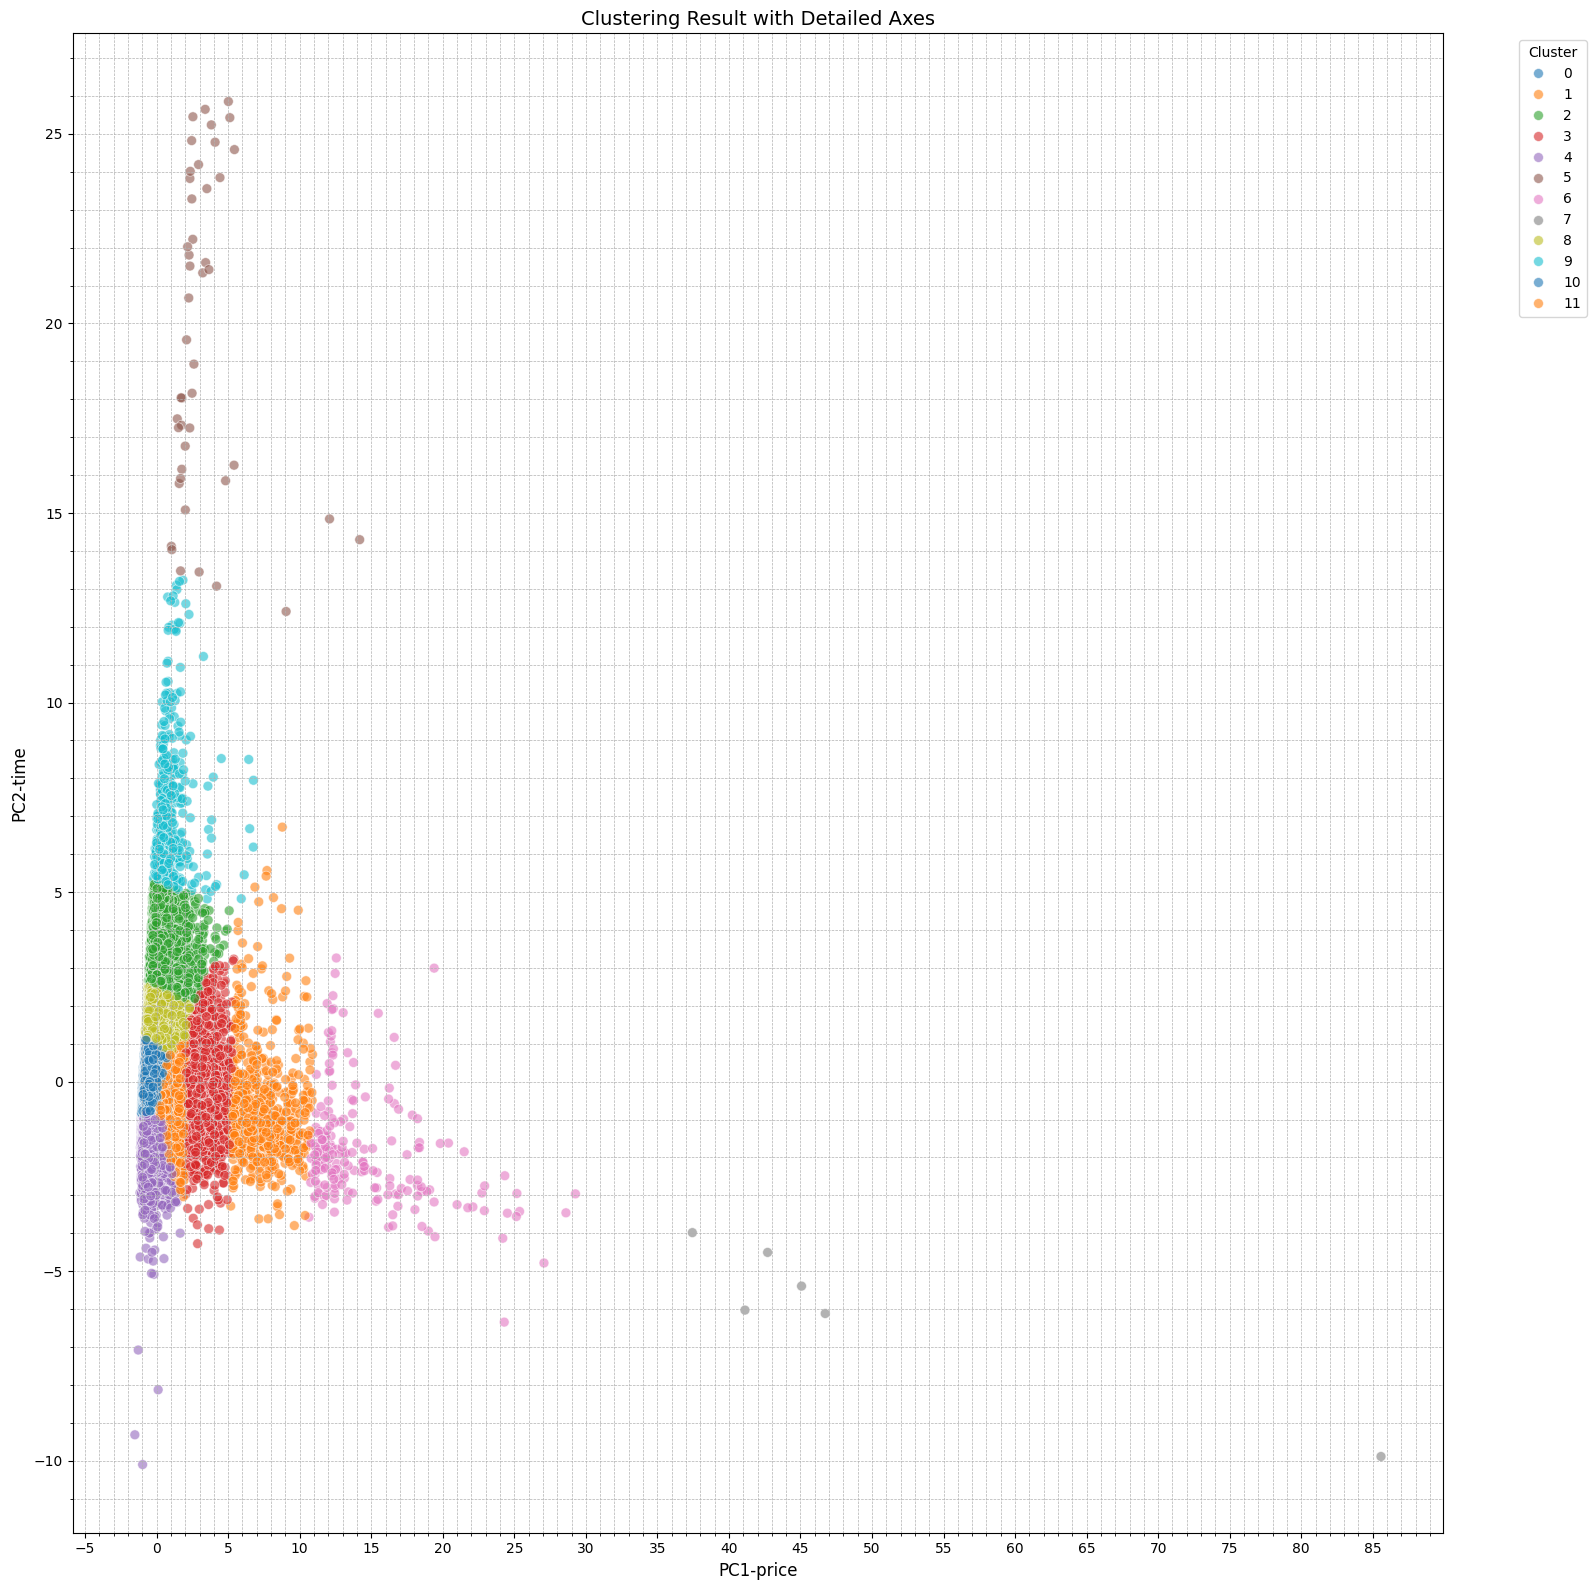

In [84]:
# 가로 16, 세로 16으로 그래프 크기 설정
plt.figure(figsize=(16, 16))  

# Scatterplot 그리기
sns.scatterplot(
    x='pc1', y='pc2', 
    hue='Cluster', 
    data=pca_df, 
    palette='tab10',  # 강렬한 색상 팔레트 사용
    s=50,  # 점 크기 조정
    alpha=0.6  # 점의 투명도 설정
)

# x축과 y축 레이블 쪼개기
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # x축 주 간격 설정 (10 단위)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))   # x축 보조 간격 설정 (2 단위)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))   # y축 주 간격 설정 (5 단위)
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))   # y축 보조 간격 설정 (1 단위)

# Grid 추가
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Title, Label, Legend 설정
plt.title('Clustering Result with Detailed Axes', fontsize=14)
plt.xlabel('PC1-price', fontsize=12)
plt.ylabel('PC2-time', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

클러스터 구분한 대로 다시 클러스터 매핑

In [85]:
# 새로운 그룹 매핑 정의
cluster_mapping = {
    5: '1',
    9: '1',
    0: '2',
    2: '2',
    8: '2',
    10: '2',
    4: '2',
    1: '3',
    3: '3',
    11: '3',
    6: '4',
    7: '4'    
}

# Cluster 값을 매핑하여 새로운 그룹 열 생성
pca_df['New_Cluster'] = pca_df['Cluster'].map(cluster_mapping)

# 결과 확인
pca_df.head()

,pc1,pc2,Cluster,New_Cluster
0,-0.157142,-0.219841,10,2
1,1.082662,0.430244,11,3
2,0.217480,1.916760,8,2
3,0.070510,0.055265,0,2
4,2.443159,-0.215729,3,3


In [87]:
# Cluster 컬럼 드랍
pca_df = pca_df.drop(columns=['Cluster'])

- New Cluster

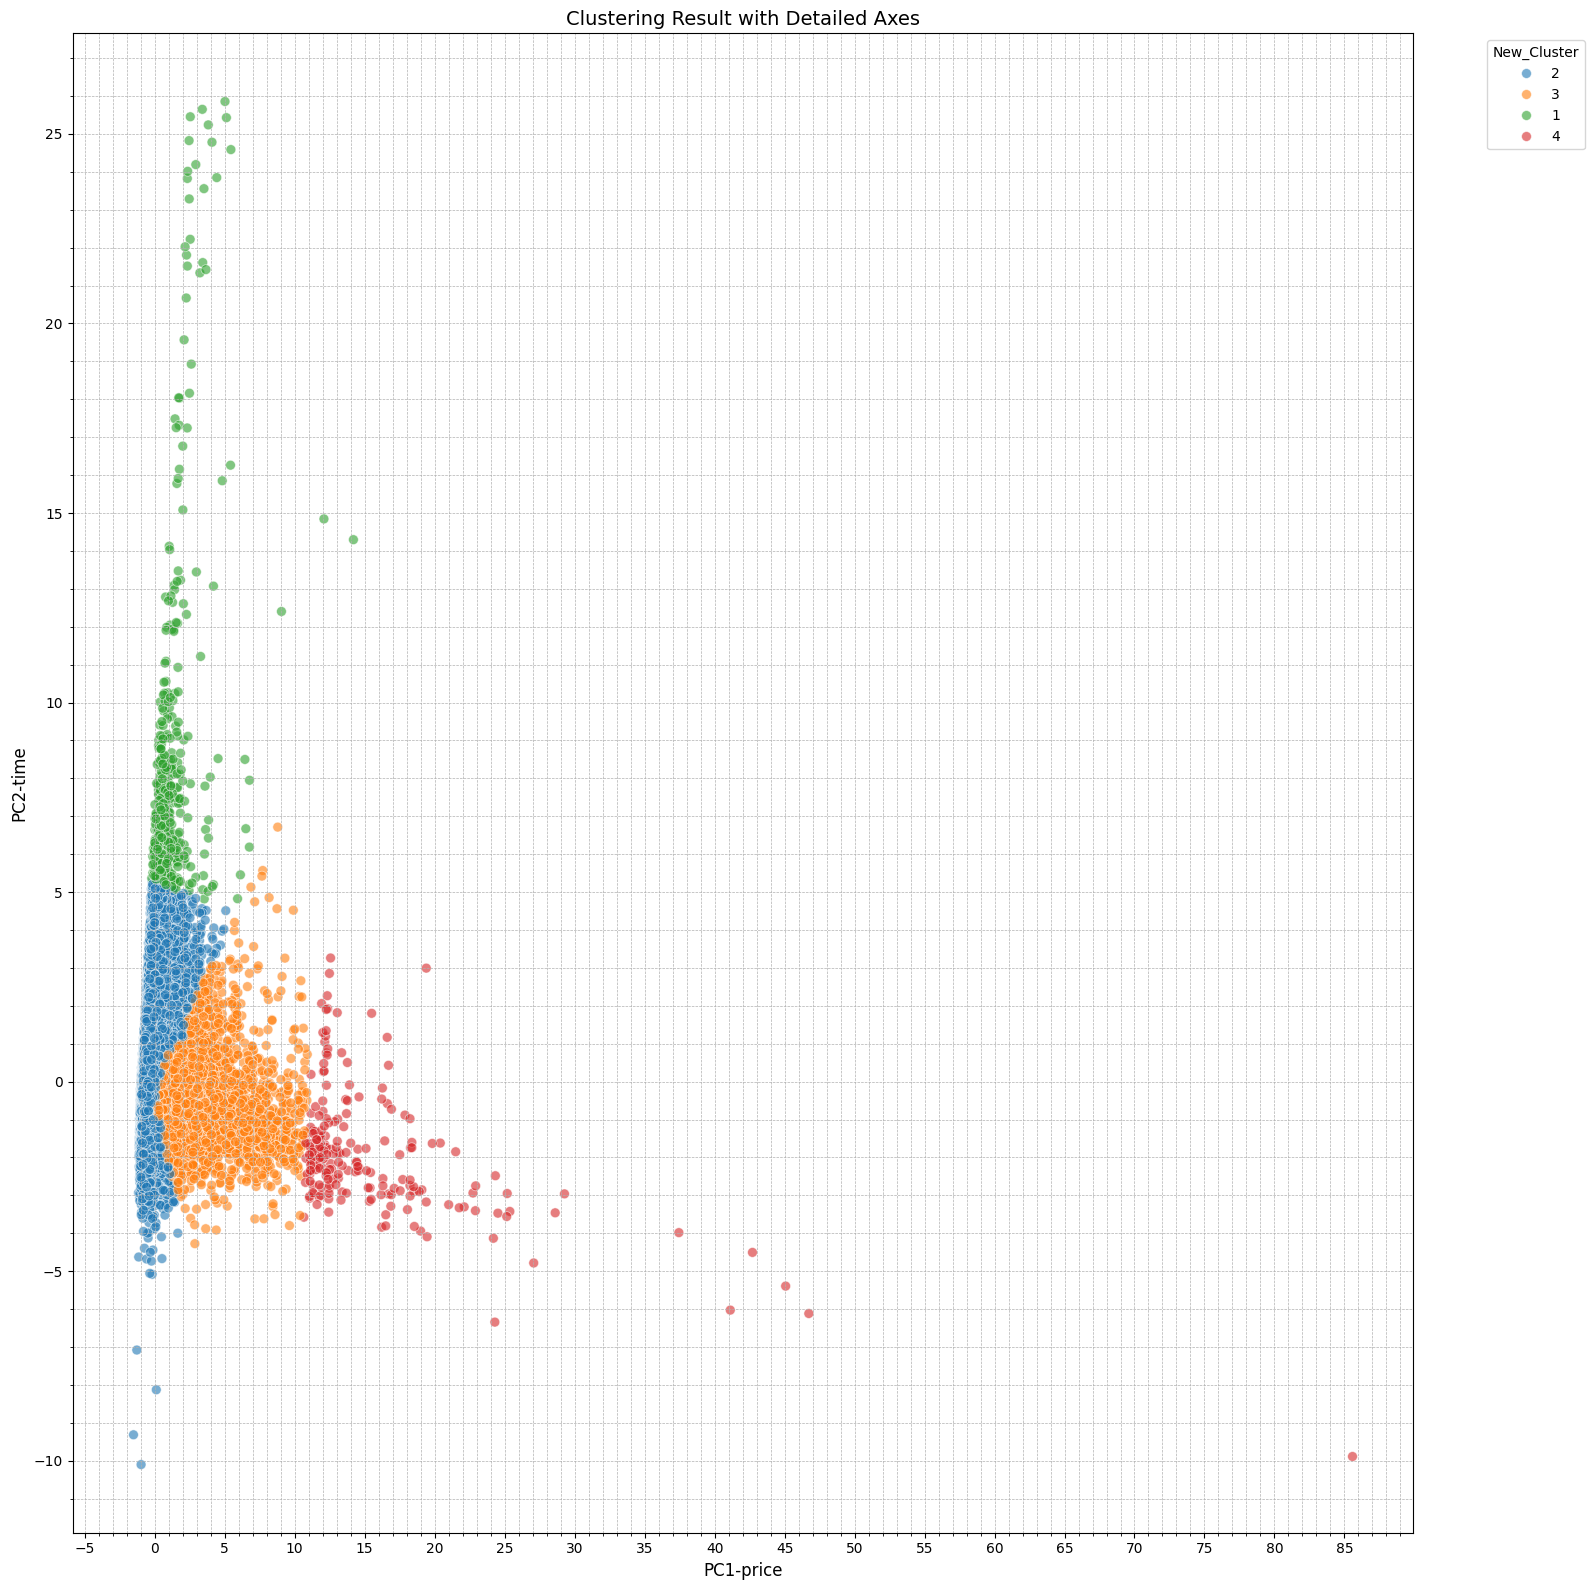

In [88]:
# 가로 16, 세로 16으로 그래프 크기 설정
plt.figure(figsize=(16, 16))  

# Scatterplot 그리기
sns.scatterplot(
    x='pc1', y='pc2', 
    hue='New_Cluster', 
    data=pca_df, 
    palette='tab10',  # 강렬한 색상 팔레트 사용
    s=50,  # 점 크기 조정
    alpha=0.6  # 점의 투명도 설정
)

# x축과 y축 레이블 쪼개기
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # x축 주 간격 설정 (10 단위)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))   # x축 보조 간격 설정 (2 단위)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))   # y축 주 간격 설정 (5 단위)
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))   # y축 보조 간격 설정 (1 단위)

# Grid 추가
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Title, Label, Legend 설정
plt.title('Clustering Result with Detailed Axes', fontsize=14)
plt.xlabel('PC1-price', fontsize=12)
plt.ylabel('PC2-time', fontsize=12)
plt.legend(title='New_Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

각 pca_df와 cluster_df를 인덱스에 맞게 다시 join

In [89]:
# 두 데이터프레임을 인덱스 기준으로 병합
result_df = cluster_df.join(pca_df[['New_Cluster']])

In [91]:
result_df.head()

,Customer_unique_id,Price,Delivery_delay_time,total_delivery_time,Monetary,New_Cluster
0,CUSTOMER_Unique_00000,124.99,-11.0,8.0,146.87,2
1,CUSTOMER_Unique_00001,289.00,-8.0,16.0,335.48,3
2,CUSTOMER_Unique_00002,139.94,1.0,26.0,157.73,2
3,CUSTOMER_Unique_00003,149.94,-13.0,14.0,173.30,2
4,CUSTOMER_Unique_00004,506.52,-10.0,11.5,565.88,3


In [92]:
# New_Cluster와 customer_unique_id만 남기고 필요없는 컬럼들 drop
result_df.drop(columns=['Price', 'Delivery_delay_time', 'total_delivery_time', 'Monetary'], inplace=True)

In [94]:
cluster_df.head()

,Customer_unique_id,Price,Delivery_delay_time,total_delivery_time,Monetary
0,CUSTOMER_Unique_00000,124.99,-11.0,8.0,146.87
1,CUSTOMER_Unique_00001,289.00,-8.0,16.0,335.48
2,CUSTOMER_Unique_00002,139.94,1.0,26.0,157.73
3,CUSTOMER_Unique_00003,149.94,-13.0,14.0,173.30
4,CUSTOMER_Unique_00004,506.52,-10.0,11.5,565.88


- 분류된 군집과 기존 df 조인

In [95]:
# 특정 열 선택 후 Customer_unique_id 기준으로 조인
df = df.merge(result_df, on='Customer_unique_id', how='left')

In [96]:
df.head()

,Order_id,Price,Product_id,Seller_id,Freight_value,Product_count,Product_category_name,Customer_id,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Delivery_delay_time,total_delivery_time,estimated_delivery_time,Payment_type,Monetary,Payment_installments,sum_credit_card,sum_boleto,sum_debit_card,sum_voucher,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Customer_unique_id,Customer_city,Frequency,Purchase_frequency_binary,Recency,New_Cluster
0,ORDER_00000,29.99,['PRODUCT_02093'],['SELLER_0491'],8.72,1,['home_utilities'],CUSTOMER_62232,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,-8,8,15,"['credit_card', 'voucher', 'voucher']",38.71,1,18.12,0.0,0.0,20.59,REVIEW_29035,4,2018-10-11 00:00:00,2018-10-12 03:43:48,CUSTOMER_Unique_60785,sao paulo,2,1,301,2
1,ORDER_00001,45.00,['PRODUCT_26747'],['SELLER_2662'],27.20,1,['pet_shop'],CUSTOMER_54059,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,-13,13,26,['credit_card'],72.20,1,72.20,0.0,0.0,0.00,REVIEW_68285,5,2018-12-03 00:00:00,2018-12-05 19:21:58,CUSTOMER_Unique_52983,sao goncalo do amarante,1,0,254,2
2,ORDER_00002,19.90,['PRODUCT_10598'],['SELLER_1354'],8.72,1,['stationery'],CUSTOMER_59535,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,-10,2,12,['credit_card'],28.62,1,28.62,0.0,0.0,0.00,REVIEW_47810,5,2019-02-17 00:00:00,2019-02-18 13:02:51,CUSTOMER_Unique_58227,santo andre,1,0,167,2
3,ORDER_00003,147.90,['PRODUCT_16703'],['SELLER_1518'],27.36,1,['automotive'],CUSTOMER_60516,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01,-6,16,22,['credit_card'],175.26,6,175.26,0.0,0.0,0.00,REVIEW_83209,4,2018-07-27 00:00:00,2018-07-27 22:48:30,CUSTOMER_Unique_59164,congonhinhas,1,0,386,2
4,ORDER_00004,59.99,['PRODUCT_08274'],['SELLER_1599'],15.17,1,['automotive'],CUSTOMER_76957,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07,-12,9,21,['credit_card'],75.16,3,75.16,0.0,0.0,0.00,REVIEW_29577,5,2018-05-27 00:00:00,2018-05-28 02:59:57,CUSTOMER_Unique_74753,nilopolis,1,0,440,2


### 클러스터별 시각화

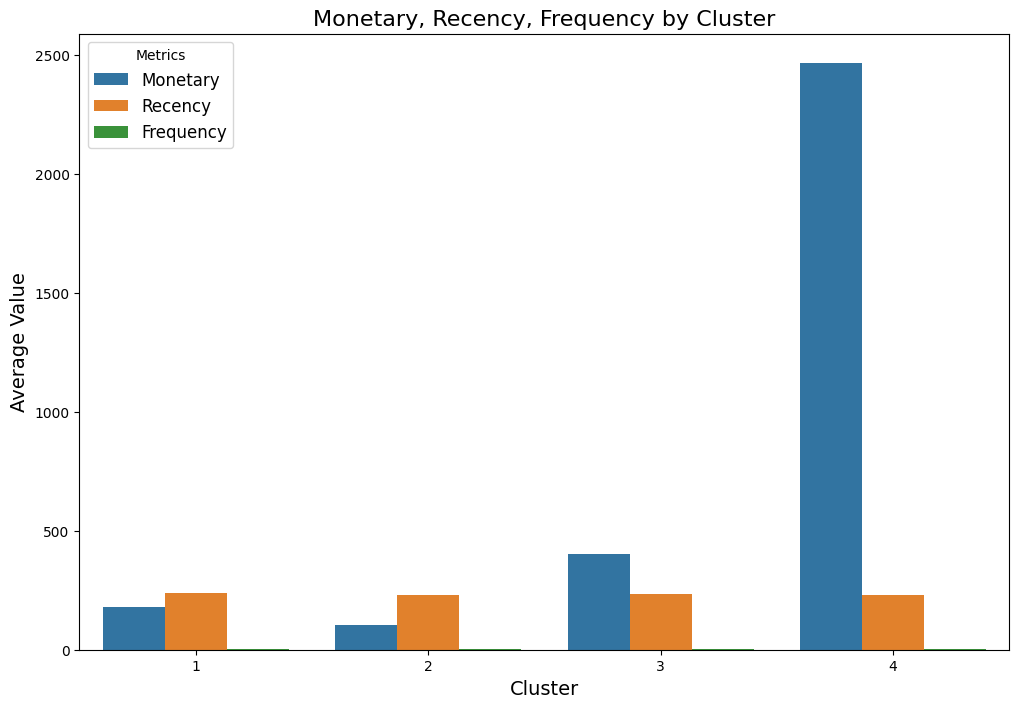

In [97]:
# 클러스터별 Monetary, Recency, Frequency 평균 계산
cluster_summary = df.groupby('New_Cluster')[['Monetary', 'Recency', 'Frequency']].mean()

# 시각화를 위해 데이터 변환 (스택 형태로 변환)
cluster_summary_melted = cluster_summary.reset_index().melt(id_vars='New_Cluster', 
                                                            var_name='Metric', 
                                                            value_name='Value')

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='New_Cluster', y='Value', hue='Metric', data=cluster_summary_melted)
plt.title('Monetary, Recency, Frequency by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(title='Metrics', fontsize=12)
plt.show()

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/293715698.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='New_Cluster', y='Monetary', data=df, ci=None, palette='viridis')
/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/293715698.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='New_Cluster', y='Monetary', data=df, ci=None, palette='viridis')


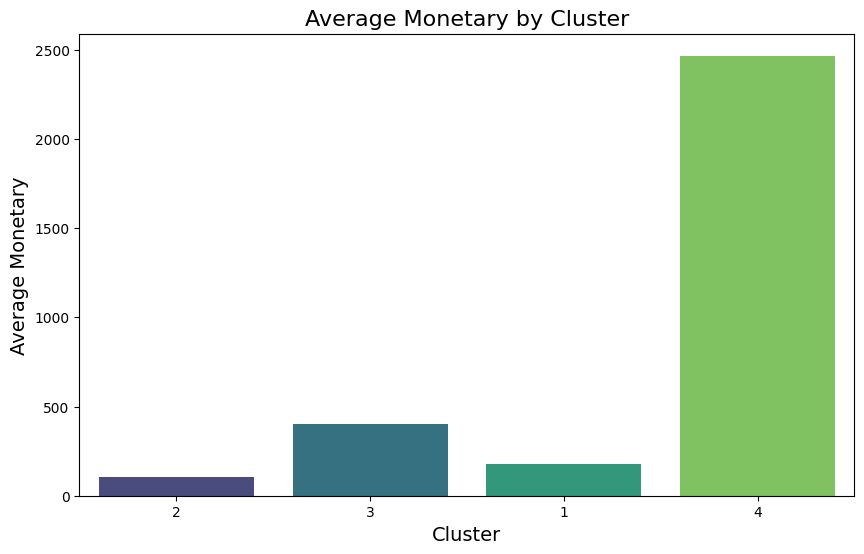

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/293715698.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='New_Cluster', y='Recency', data=df, ci=None, palette='coolwarm')
/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/293715698.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='New_Cluster', y='Recency', data=df, ci=None, palette='coolwarm')


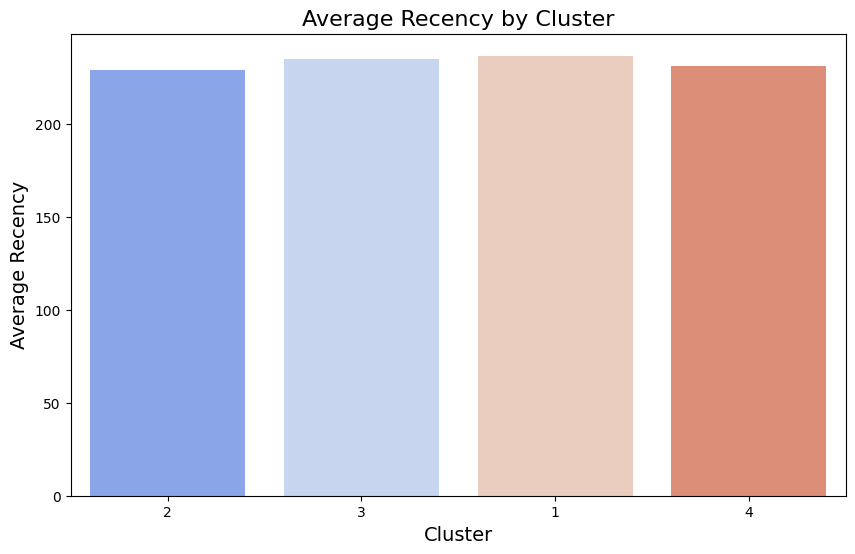

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/293715698.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='New_Cluster', y='Frequency', data=df, ci=None, palette='plasma')
/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/293715698.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='New_Cluster', y='Frequency', data=df, ci=None, palette='plasma')


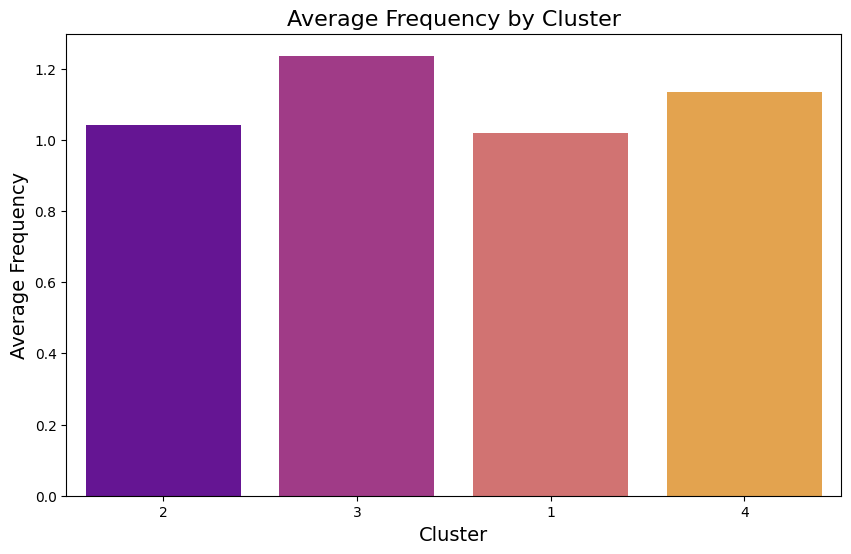

In [98]:
# 클러스터별 Monetary 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='New_Cluster', y='Monetary', data=df, ci=None, palette='viridis')
plt.title('Average Monetary by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Monetary', fontsize=14)
plt.show()

# 클러스터별 Recency 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='New_Cluster', y='Recency', data=df, ci=None, palette='coolwarm')
plt.title('Average Recency by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Recency', fontsize=14)
plt.show()

# 클러스터별 Frequency 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='New_Cluster', y='Frequency', data=df, ci=None, palette='plasma')
plt.title('Average Frequency by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Frequency', fontsize=14)
plt.show()

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/1769141586.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='New_Cluster', y='Review_score', data=df, ci=None, palette='tab10')
/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/1769141586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='New_Cluster', y='Review_score', data=df, ci=None, palette='tab10')


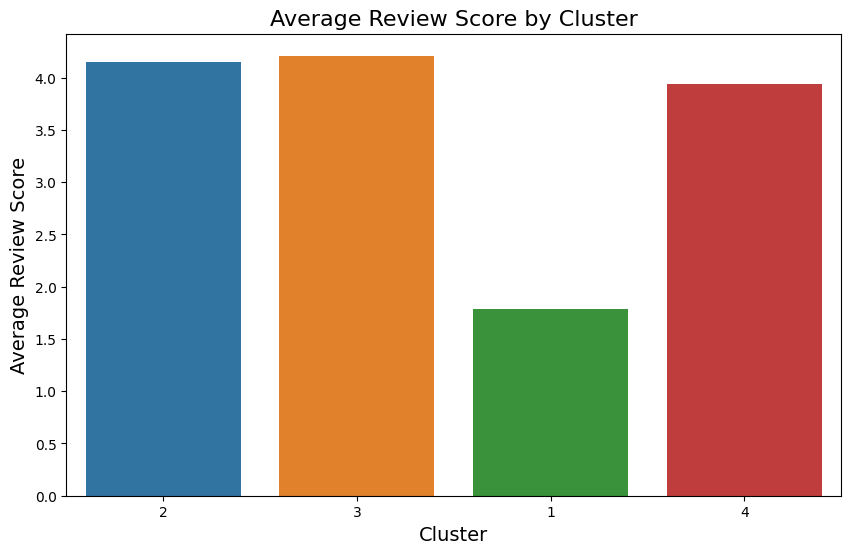

In [99]:
# 클러스터 별 Review_score 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='New_Cluster', y='Review_score', data=df, ci=None, palette='tab10')
plt.title('Average Review Score by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Review Score', fontsize=14)
plt.show()

In [ ]:
# 제품 별 시각화를 위해 list로 저장되어 있는 컬럼 풀기
df_exploded = df.explode('Product_category_name')

상위 10개 제품 클러스터 별 구매 횟수

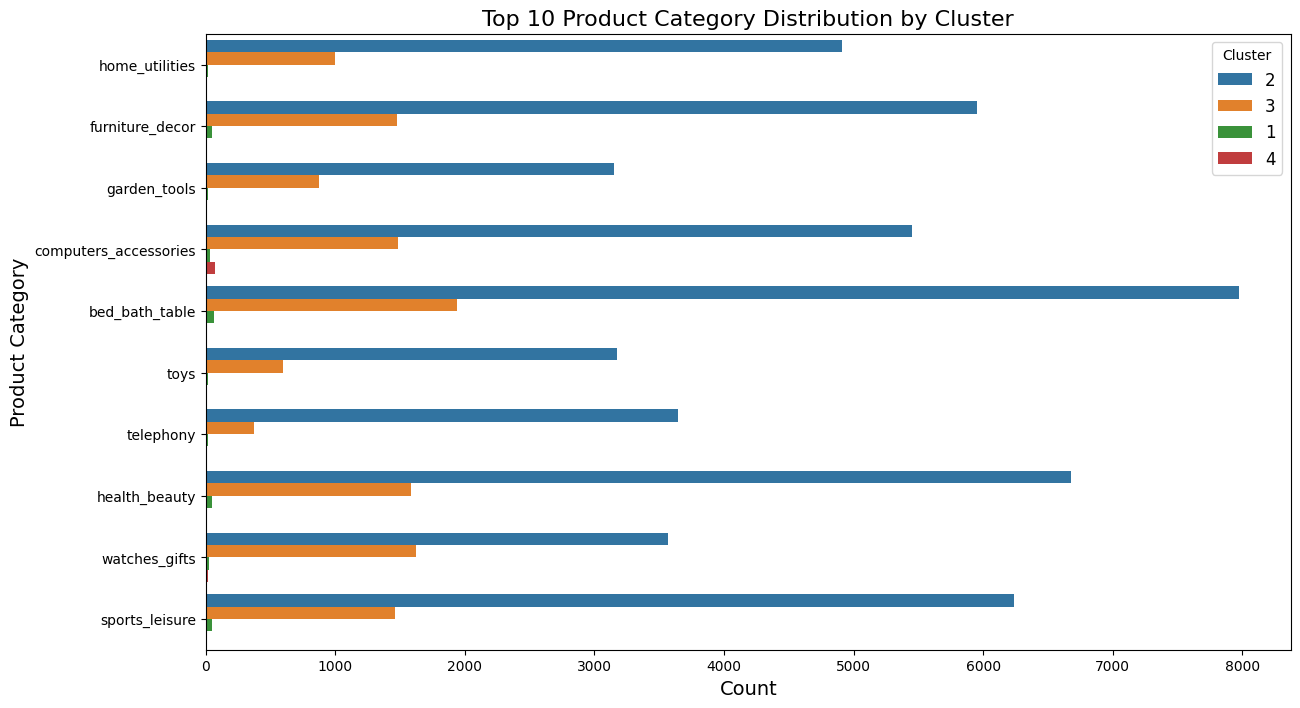

In [166]:
# 상위 10개 Product_category_name 추출
top_categories = (
    df_exploded['Product_category_name']
    .value_counts()
    .head(10)
    .index
)

# 상위 10개 카테고리 필터링
filtered_df = df_exploded[df_exploded['Product_category_name'].isin(top_categories)]

# 시각화
plt.figure(figsize=(14, 8))
sns.countplot(
    y='Product_category_name', 
    hue='New_Cluster', 
    data=filtered_df, 
    palette='tab10'
)
plt.title('Top 10 Product Category Distribution by Cluster', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Product Category', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.show()

클러스터 4에서만 상위 카테고리 구매 제품 파악

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/643898531.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


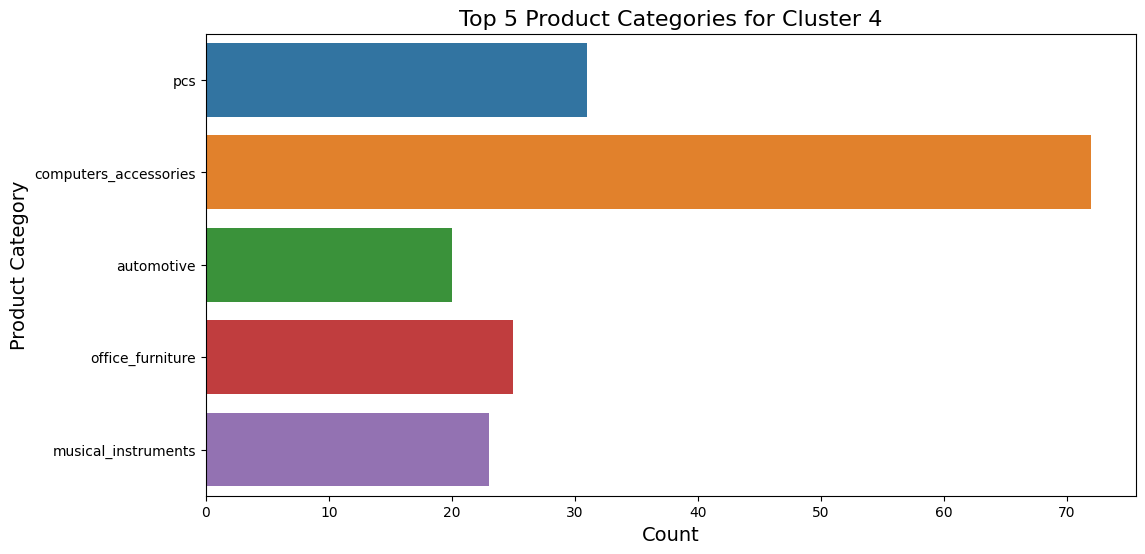

In [113]:
# 클러스터 4만 필터링
cluster_4_df = df_exploded[df_exploded['New_Cluster'] == '4']

# 클러스터 4에서 상위 5개 카테고리 추출
top_5_categories = (
    cluster_4_df['Product_category_name']
        .value_counts()
        .head(5)
        .index
)

# 상위 5개 카테고리로 필터링
cluster_4_top_5_df = cluster_4_df[cluster_4_df['Product_category_name'].isin(top_5_categories)]

# 시각화
plt.figure(figsize=(12, 6))
sns.countplot(
    y='Product_category_name',
    data=cluster_4_top_5_df,
    palette='tab10'
)
plt.title('Top 5 Product Categories for Cluster 4', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Product Category', fontsize=14)
plt.show()

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/2228283818.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='New_Cluster', y='Frequency', data=cluster_frequency_mean, palette='tab10')


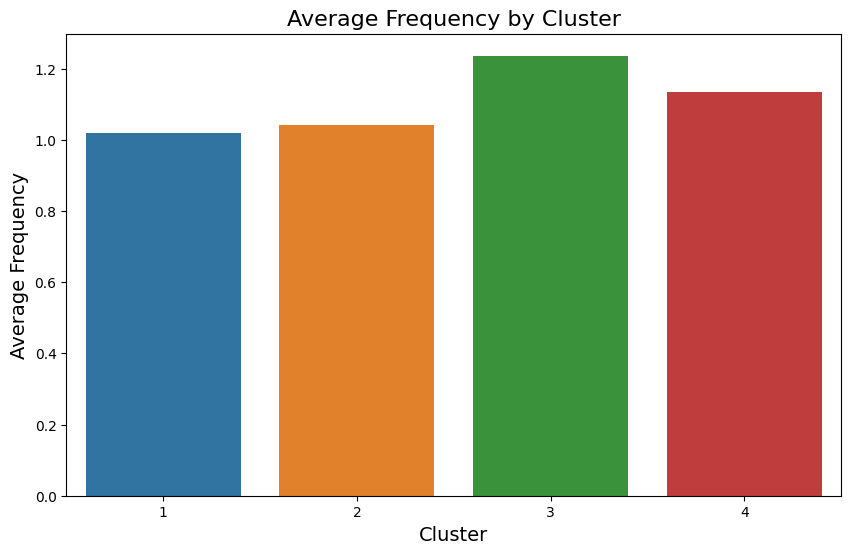

In [114]:
# 클러스터별 Frequency 평균 계산
cluster_frequency_mean = df.groupby('New_Cluster')['Frequency'].mean().reset_index()

# 클러스터별 Frequency 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='New_Cluster', y='Frequency', data=cluster_frequency_mean, palette='tab10')
plt.title('Average Frequency by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Frequency', fontsize=14)
plt.show()

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_37524/2985216307.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='New_Cluster', y='Payment_installments', data=cluster_payment_mean, palette='tab10')


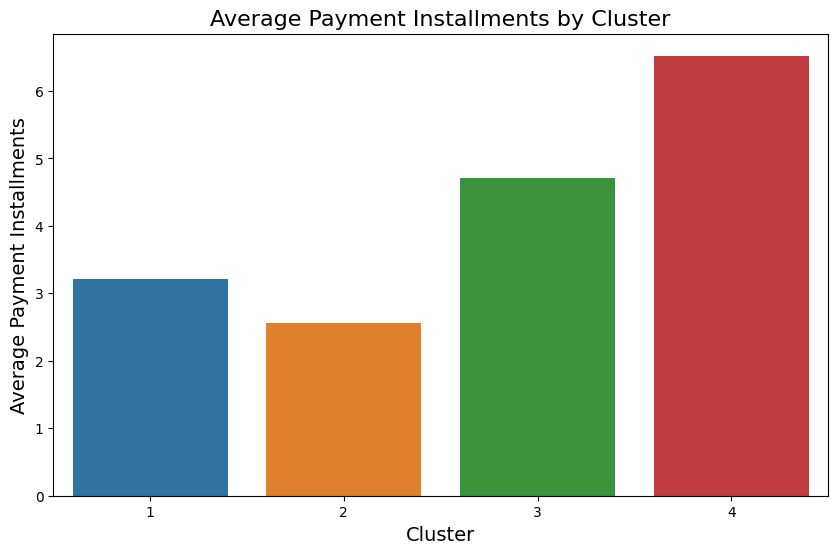

In [912]:
# 클러스터별 Payment_installments 평균 계산
cluster_payment_mean = df.groupby('New_Cluster')['Payment_installments'].mean().reset_index()

# 클러스터별 Payment_installments 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='New_Cluster', y='Payment_installments', data=cluster_payment_mean, palette='tab10')
plt.title('Average Payment Installments by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Payment Installments', fontsize=14)
plt.show()


  New_Cluster  Purchase_frequency_binary  Count
0           1                          0    505
1           1                          1     10
2           2                          0  69060
3           2                          1   2798
4           3                          0  12231
5           3                          1   2520
6           4                          0    200
7           4                          1     24


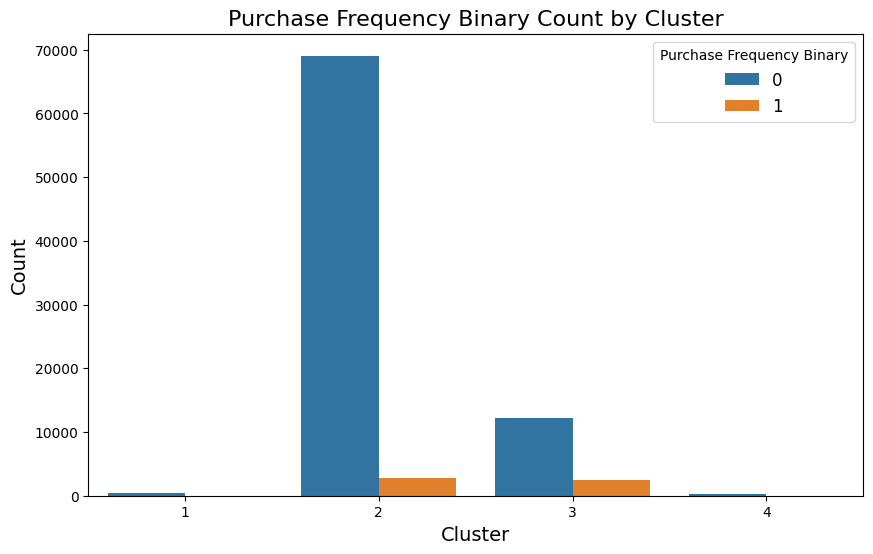

In [115]:
# 클러스터별 Purchase_frequency_binary 개수 파악
cluster_purchase_count = df.groupby(['New_Cluster', 'Purchase_frequency_binary']).size().reset_index(name='Count')

# 결과 출력
print(cluster_purchase_count)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='New_Cluster', 
    y='Count', 
    hue='Purchase_frequency_binary', 
    data=cluster_purchase_count, 
    palette='tab10'
)
plt.title('Purchase Frequency Binary Count by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Purchase Frequency Binary', fontsize=12)
plt.show()


In [117]:
# 클러스터별 Purchase_frequency_binary 개수 파악
cluster_purchase_count = df.groupby(['New_Cluster', 'Purchase_frequency_binary']).size().reset_index(name='Count')

# 클러스터별 총합 계산
cluster_total = cluster_purchase_count.groupby('New_Cluster')['Count'].sum().reset_index(name='Total')

# 비율 계산
cluster_purchase_count = cluster_purchase_count.merge(cluster_total, on='New_Cluster')
cluster_purchase_count['Percentage'] = (cluster_purchase_count['Count'] / cluster_purchase_count['Total']) * 100

# 결과를 표 형태로 정리
cluster_purchase_table = cluster_purchase_count.pivot_table(
    index='New_Cluster', 
    columns='Purchase_frequency_binary', 
    values='Percentage', 
    aggfunc='sum'
)

# 결과 출력
print(cluster_purchase_table)


Purchase_frequency_binary          0          1
New_Cluster                                    
1                          98.058252   1.941748
2                          96.106209   3.893791
3                          82.916412  17.083588
4                          89.285714  10.714286


  New_Cluster  Delivery_delay_time
0           1            42.941748
1           2           -12.201996
2           3           -14.462816
3           4           -13.223214


/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/4273510844.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


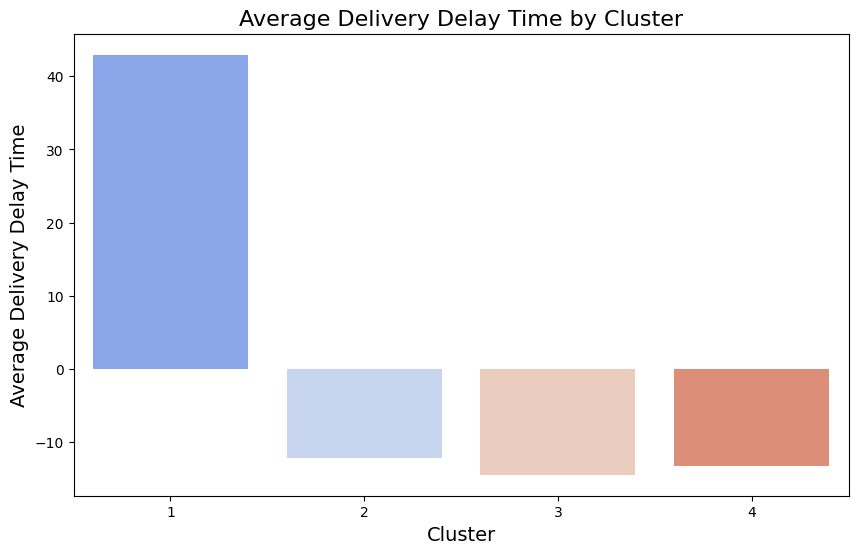

In [118]:
# 클러스터별 Delivery_delay_time 평균 계산
cluster_delay_mean = df.groupby('New_Cluster')['Delivery_delay_time'].mean().reset_index()

# 결과 출력
print(cluster_delay_mean)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='New_Cluster', 
    y='Delivery_delay_time', 
    data=cluster_delay_mean, 
    palette='coolwarm'
)
plt.title('Average Delivery Delay Time by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Delivery Delay Time', fontsize=14)
plt.show()


  New_Cluster  Product_count
0           1       1.077670
1           2       1.101158
2           3       1.336926
3           4       1.669643


/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/217960402.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


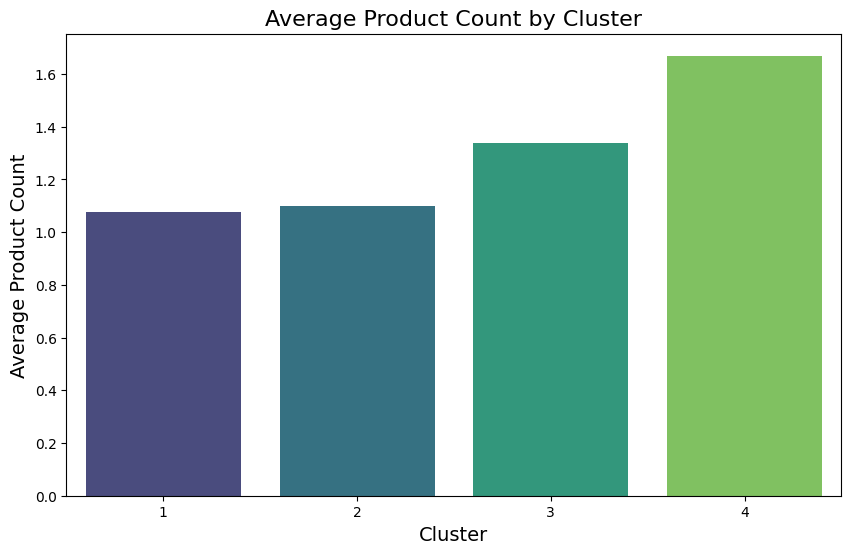

In [119]:
# 클러스터별 Product_count 평균 계산
cluster_product_count_mean = df.groupby('New_Cluster')['Product_count'].mean().reset_index()

# 결과 출력
print(cluster_product_count_mean)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='New_Cluster', 
    y='Product_count', 
    data=cluster_product_count_mean, 
    palette='viridis'
)
plt.title('Average Product Count by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Product Count', fontsize=14)
plt.show()


/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/636017213.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


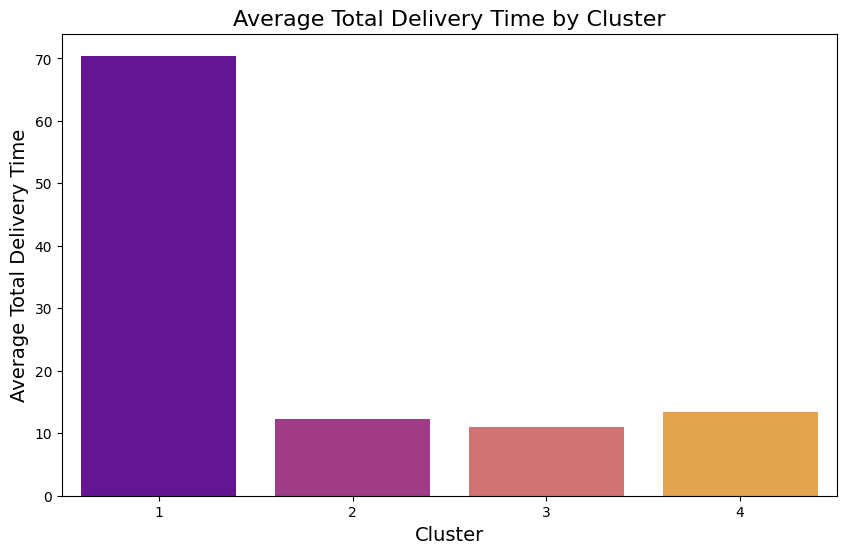

In [120]:
# 클러스터별 total_delivery_time 평균 계산
cluster_delivery_time_mean = df.groupby('New_Cluster')['total_delivery_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x='New_Cluster', 
    y='total_delivery_time', 
    data=cluster_delivery_time_mean, 
    palette='plasma'
)
plt.title('Average Total Delivery Time by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Total Delivery Time', fontsize=14)
plt.show()

/var/folders/jn/6v9ffl5x6gvf4y16kqq_wqgh0000gn/T/ipykernel_17410/3383063497.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


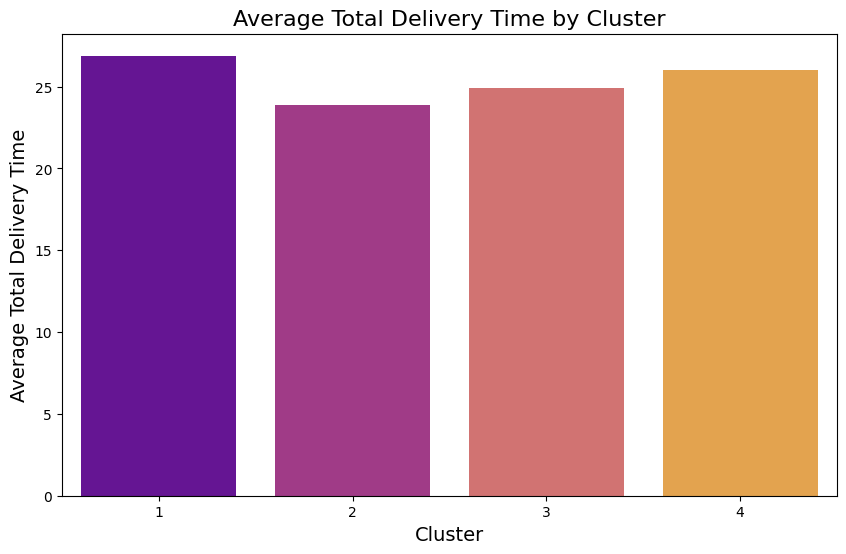

In [121]:
# 클러스터별 total_delivery_time 평균 계산
cluster_delivery_time_mean = df.groupby('New_Cluster')['estimated_delivery_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x='New_Cluster', 
    y='estimated_delivery_time', 
    data=cluster_delivery_time_mean, 
    palette='plasma'
)
plt.title('Average Total Delivery Time by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Total Delivery Time', fontsize=14)
plt.show()


In [122]:
# 클러스터별 'sum_credit_card', 'sum_boleto', 'sum_debit_card', 'sum_voucher'의 평균 계산
cluster_means = df.groupby('New_Cluster')[['sum_credit_card', 'sum_boleto', 'sum_debit_card', 'sum_voucher']].mean()

# 결과 출력
print(cluster_means)

             sum_credit_card  sum_boleto  sum_debit_card  sum_voucher
New_Cluster                                                          
1                 143.130311   29.910194        1.257262     5.690951
2                  78.230776   19.922811        1.265948     2.892929
3                 326.417482   65.457128        2.961215     6.973036
4                1905.529018  506.232634       48.852589     6.312455


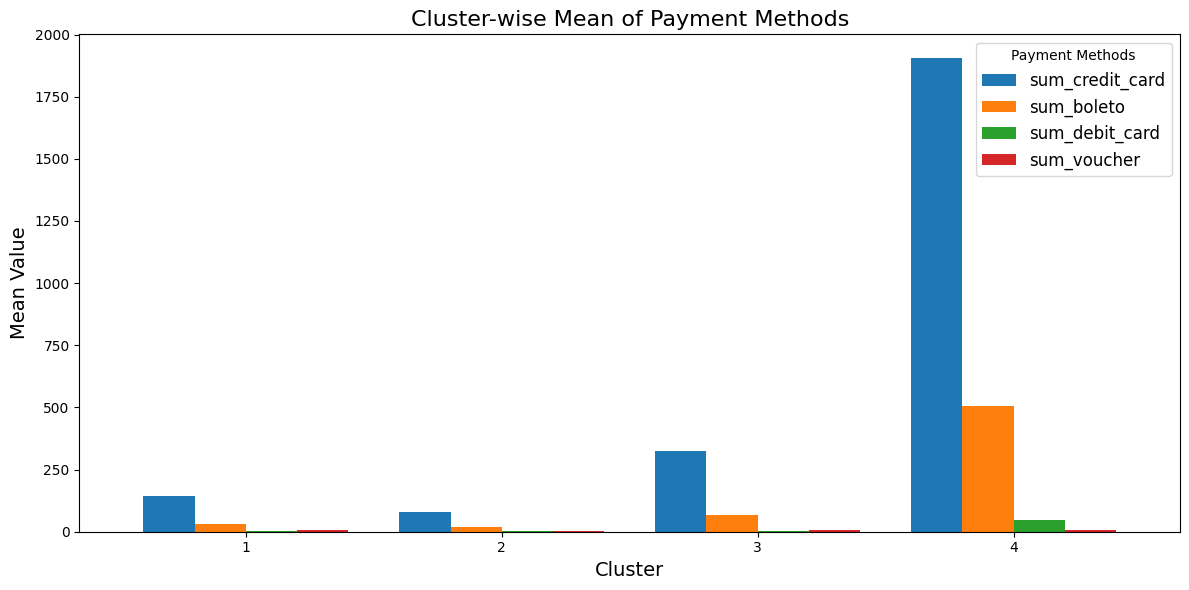

In [123]:
# 클러스터별 평균 값 시각화
cluster_means.plot(kind='bar', figsize=(12, 6), width=0.8)

# 그래프 제목 및 축 레이블 설정
plt.title('Cluster-wise Mean of Payment Methods', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Payment Methods', fontsize=12)
plt.tight_layout()
plt.show()


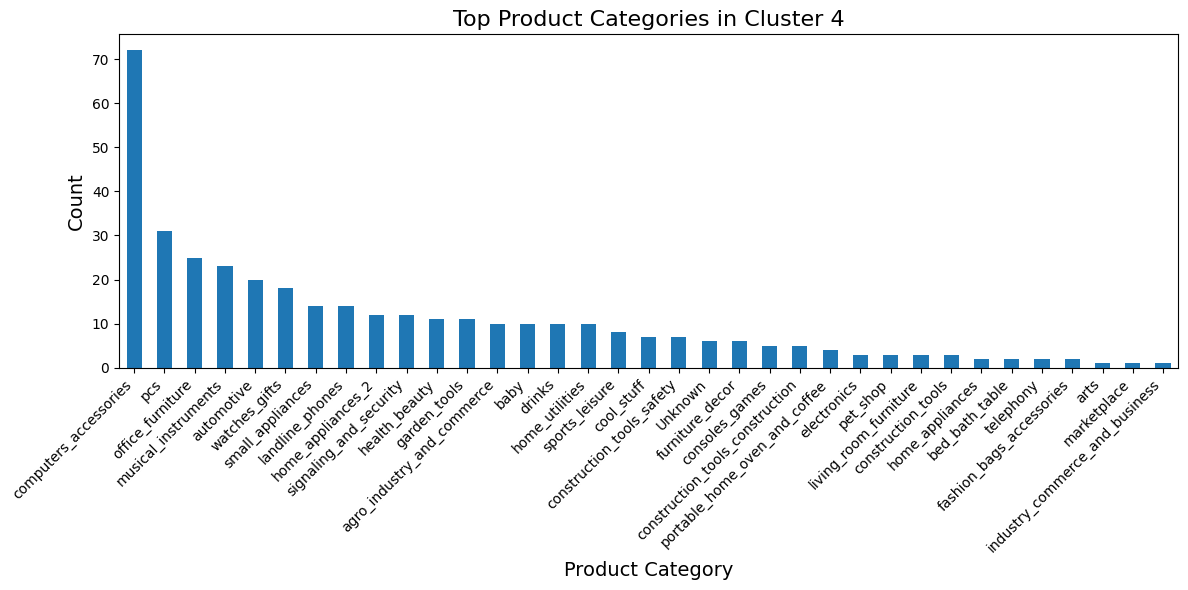

In [124]:
# Product_category_name 리스트를 풀어내기 (explode 활용)
model_df_exploded = df.explode('Product_category_name')

# 4번 클러스터 데이터 필터링
cluster_4_df = model_df_exploded[model_df_exploded['New_Cluster'] == '4']

# Product_category_name 기준으로 값 카운트
category_counts = cluster_4_df['Product_category_name'].value_counts()


plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Top Product Categories in Cluster 4', fontsize=16)
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Modeling

### 학습 & 테스트 셋 준비 작업

In [126]:
# 모델링에 필요없는 컬럼 리스트
columns_to_drop = [
    'Order_id', 'Product_id', 'Seller_id', 'Customer_id', 'Order_purchase_timestamp', 
    'Order_delivered_carrier_date', 'Order_delivered_customer_date', 
    'Order_estimated_delivery_date', 'Review_id', 'Review_creation_date', 
    'Review_answer_timestamp', 'Payment_type', 'Frequency' # Frequency는 타깃에 직접적인 요인이기에 삭제
]

# 컬럼 드랍
model_df = df.drop(columns=columns_to_drop)

# 결과 확인
print("Columns after dropping:", model_df.columns)

Columns after dropping: Index(['Price', 'Freight_value', 'Product_count', 'Product_category_name',
       'Delivery_delay_time', 'total_delivery_time', 'estimated_delivery_time',
       'Monetary', 'Payment_installments', 'sum_credit_card', 'sum_boleto',
       'sum_debit_card', 'sum_voucher', 'Review_score', 'Customer_unique_id',
       'Customer_city', 'Purchase_frequency_binary', 'Recency', 'New_Cluster'],
      dtype='object')


In [127]:
# 클러스터가 2 또는 3인 데이터만 추출
filtered_df = model_df[model_df['New_Cluster'].isin(['2', '3'])]

In [ ]:
# 모델링에는 New_Cluster가 없기에 Drop
filtered_df = filtered_df.drop(columns='New_Cluster')

In [129]:
# Customer_unique_id가 고유한 데이터프레임 생성
unique_customers = model_df.drop_duplicates(subset='Customer_unique_id')

In [131]:
# 최종 확인할 이진 변수 개수 확인
filtered_df['Purchase_frequency_binary'].value_counts()

Purchase_frequency_binary
0    81291
1     5318
Name: count, dtype: int64

In [132]:
# Product_category_name과 Payment_type 컬럼의 리스트를 풀어줌 (라벨링을 위해 단순히 str로 변환)
filtered_df['Product_category_name'] = filtered_df['Product_category_name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# 결과 확인
filtered_df

,Price,Freight_value,Product_count,Product_category_name,Delivery_delay_time,total_delivery_time,estimated_delivery_time,Monetary,Payment_installments,sum_credit_card,sum_boleto,sum_debit_card,sum_voucher,Review_score,Customer_unique_id,Customer_city,Purchase_frequency_binary,Recency
0,29.99,8.72,1,home_utilities,-8,8,15,38.71,1,18.12,0.0,0.00,20.59,4,CUSTOMER_Unique_60785,sao paulo,1,301
1,45.00,27.20,1,pet_shop,-13,13,26,72.20,1,72.20,0.0,0.00,0.00,5,CUSTOMER_Unique_52983,sao goncalo do amarante,0,254
2,19.90,8.72,1,stationery,-10,2,12,28.62,1,28.62,0.0,0.00,0.00,5,CUSTOMER_Unique_58227,santo andre,0,167
3,147.90,27.36,1,automotive,-6,16,22,175.26,6,175.26,0.0,0.00,0.00,4,CUSTOMER_Unique_59164,congonhinhas,0,386
4,59.99,15.17,1,automotive,-12,9,21,75.16,3,75.16,0.0,0.00,0.00,5,CUSTOMER_Unique_74753,nilopolis,0,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87343,72.00,13.08,1,health_beauty,-11,8,18,85.08,3,85.08,0.0,0.00,0.00,5,CUSTOMER_Unique_52545,sao jose dos campos,0,508
87344,174.90,20.10,1,baby,-2,22,23,195.00,3,195.00,0.0,0.00,0.00,4,CUSTOMER_Unique_67637,praia grande,0,174
87345,205.99,65.02,1,home_appliances_2,-6,24,30,271.01,5,271.01,0.0,0.00,0.00,5,CUSTOMER_Unique_17508,nova vicosa,0,337
87346,359.98,81.18,2,"computers_accessories, computers_accessories",-21,17,37,441.16,4,441.16,0.0,0.00,0.00,2,CUSTOMER_Unique_14906,japuiba,0,203


모델 학습을 위해 label 수를 똑같이 Sampling하여 학습을 진행함.

In [133]:
# 타겟 값이 1인 데이터에서 5352개 무작위 추출
target_1_sample = filtered_df[filtered_df['Purchase_frequency_binary'] == 1].sample(n=5318, random_state=42)

# 타겟 값이 0인 데이터에서 5352개 무작위 추출
target_0_sample = filtered_df[filtered_df['Purchase_frequency_binary'] == 0].sample(n=5318, random_state=42)

# 두 데이터를 결합
balanced_df = pd.concat([target_1_sample, target_0_sample])

In [134]:
print(balanced_df['Purchase_frequency_binary'].value_counts())

Purchase_frequency_binary
1    5318
0    5318
Name: count, dtype: int64


In [137]:
# 텍스트 데이터를 단순히 Label링으로 변환함.
# 여러 실험 결과, 벡터화하는 것보다 단순히 라벨링하는 것이 더 성능이 좋은 것을 확인.

encoder = LabelEncoder()
balanced_df['Product_category_name'] = encoder.fit_transform(balanced_df['Product_category_name'])
balanced_df['Customer_city'] = encoder.fit_transform(balanced_df['Customer_city'])

In [138]:
# 특성과 타겟 변수 분리
X = balanced_df.drop(columns=['Purchase_frequency_binary', 'Customer_unique_id'])
y = balanced_df['Purchase_frequency_binary']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### Decision Tree

In [142]:
# Decision Tree 모델 생성 및 훈련
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,              # 트리 최대 깊이
    min_samples_split=10,     # 분할을 위한 최소 샘플 수
    min_samples_leaf=10,       # 리프 노드 최소 샘플 수
    max_features='sqrt',      # 분할에 사용할 최대 피처 수
    criterion='gini',         # 지니 계수를 기준으로 분할
)

dt_model.fit(X_train, y_train)

# 예측
y_pred = dt_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # F1-Score (가중 평균)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
print("\nClassification Report:\n", report)

Decision Tree Accuracy: 0.5569
F1-Score (Weighted): 0.5508

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.67      0.60      1596
           1       0.57      0.44      0.50      1595

    accuracy                           0.56      3191
   macro avg       0.56      0.56      0.55      3191
weighted avg       0.56      0.56      0.55      3191



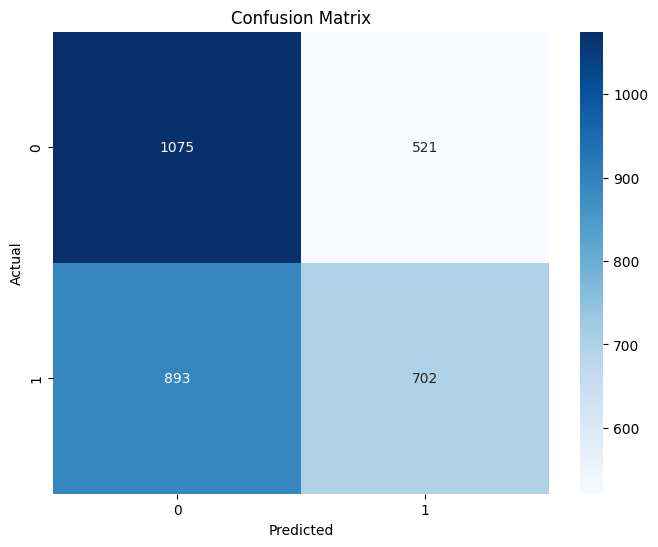

In [143]:
# 예측값 및 실제값으로 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

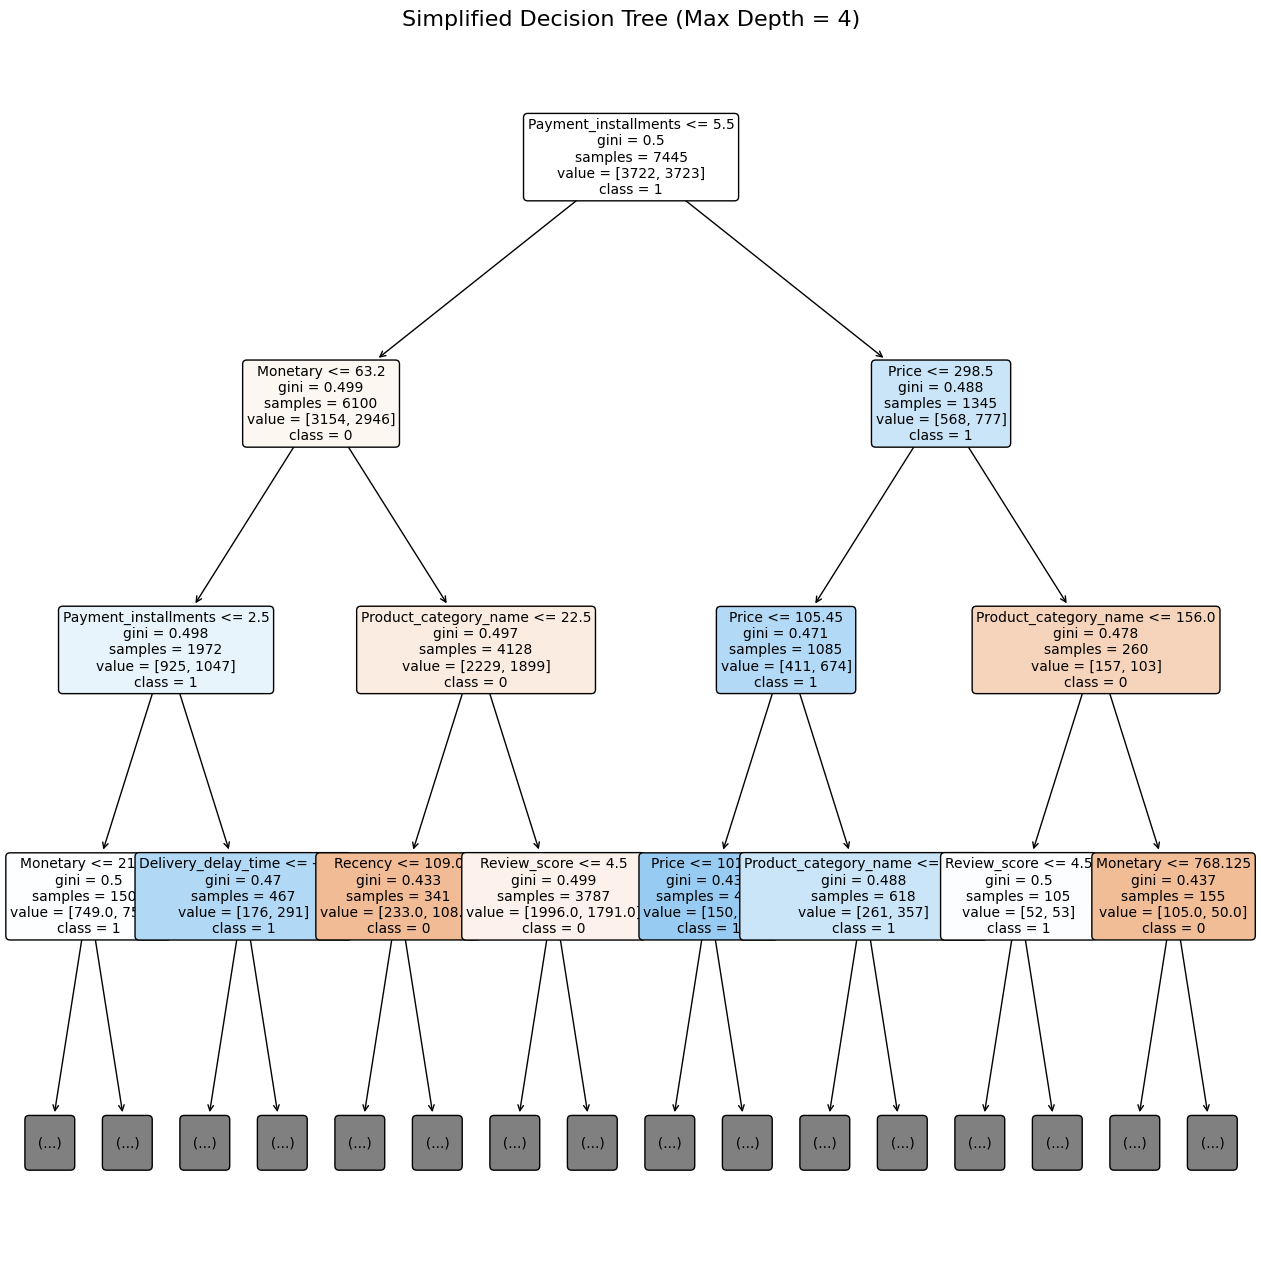

In [144]:
# 트리 시각화 (깊이 제한)
plt.figure(figsize=(16, 16))  # 그림 크기 설정
plot_tree(
    dt_model,
    feature_names=X_train.columns,  # 피처 이름
    class_names=[str(cls) for cls in dt_model.classes_],  # 클래스 이름
    filled=True,                # 노드 색상
    rounded=True,               # 둥근 노드
    fontsize=10,                # 폰트 크기
    max_depth=3                 # 최대 깊이를 4로 제한
)
plt.title("Simplified Decision Tree (Max Depth = 4)", fontsize=16)
plt.show()

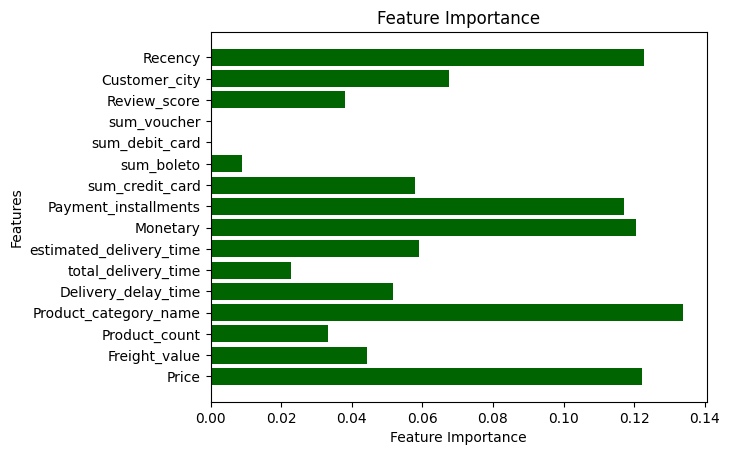

In [145]:
# 특성 중요도 시각화 생성
feature_importances = dt_model.feature_importances_
plt.barh(X_train.columns, feature_importances, color='darkgreen')  # 색상을 진한 녹색으로 설정
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### Random Forest

In [151]:
# 랜덤포레스트 모델 생성

# 하이퍼파라미터 조정
rf_model = RandomForestClassifier(
    n_estimators=200,       # 트리의 개수
    max_depth=20,           # 최대 트리 깊이
    min_samples_split=10,    # 내부 노드를 분할하기 위한 최소 샘플 수
    min_samples_leaf=3,     # 리프 노드의 최소 샘플 수
    max_features='sqrt',    # 각 분할에서 고려할 특징의 수
    bootstrap=True,         # 부트스트랩 샘플링 사용
    random_state=42         # 재현성 확보
)

# 훈련
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

Decision Tree Accuracy: 0.5964

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.62      0.61      1596
           1       0.60      0.57      0.58      1595

    accuracy                           0.60      3191
   macro avg       0.60      0.60      0.60      3191
weighted avg       0.60      0.60      0.60      3191



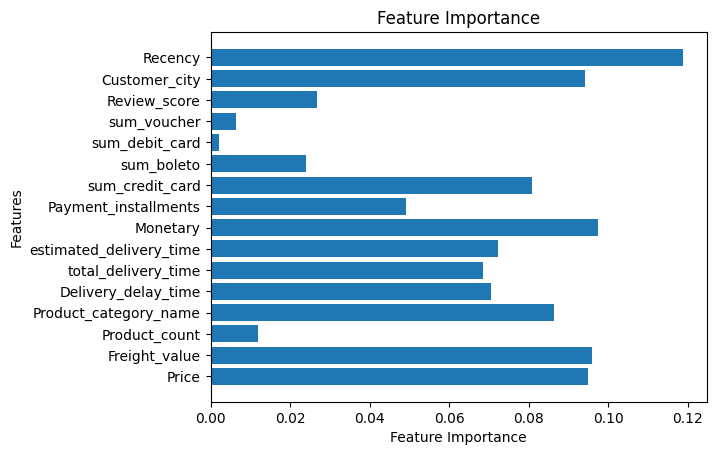

In [152]:
feature_importances = rf_model.feature_importances_
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### LightGBM

In [ ]:
# LightGBM 모델 생성
lgb_model = LGBMClassifier(random_state=42)

In [154]:
# 훈련
lgb_model.fit(X_train, y_train)

# 예측
y_pred = lgb_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

[LightGBM] [Info] Number of positive: 3723, number of negative: 3722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 7445, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500067 -> initscore=0.000269
[LightGBM] [Info] Start training from score 0.000269
Decision Tree Accuracy: 0.5866

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.62      0.60      1596
           1       0.59      0.55      0.57      1595

    accuracy                           0.59      3191
   macro avg       0.59      0.59      0.59      3191
weighted avg       0.59      0.59      0.59      3191



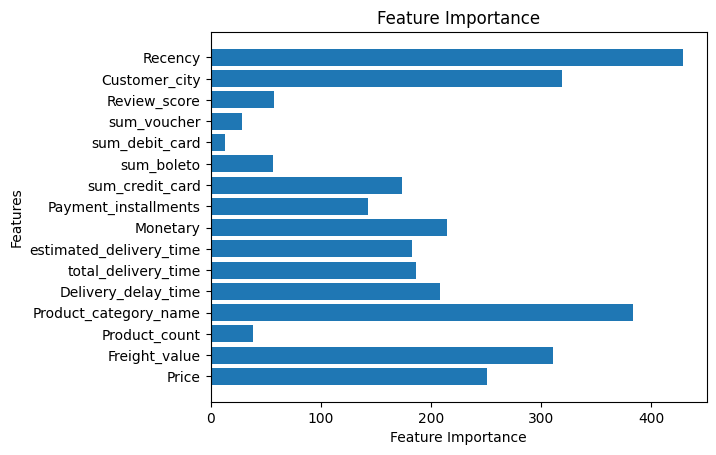

In [155]:
feature_importances = lgb_model.feature_importances_
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### XGBoost

In [ ]:
# XGBoost 모델 생성
xgb_model = XGBClassifier(random_state=42)

In [157]:
# 훈련
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

Decision Tree Accuracy: 0.5873

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.60      1596
           1       0.59      0.56      0.58      1595

    accuracy                           0.59      3191
   macro avg       0.59      0.59      0.59      3191
weighted avg       0.59      0.59      0.59      3191



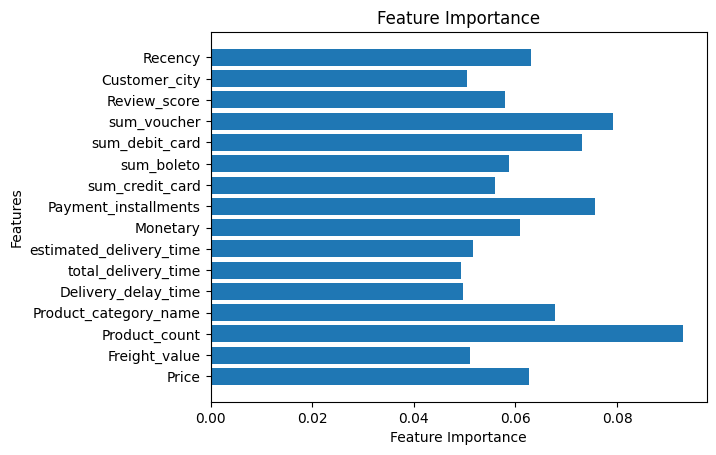

In [159]:
feature_importances = xgb_model.feature_importances_
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

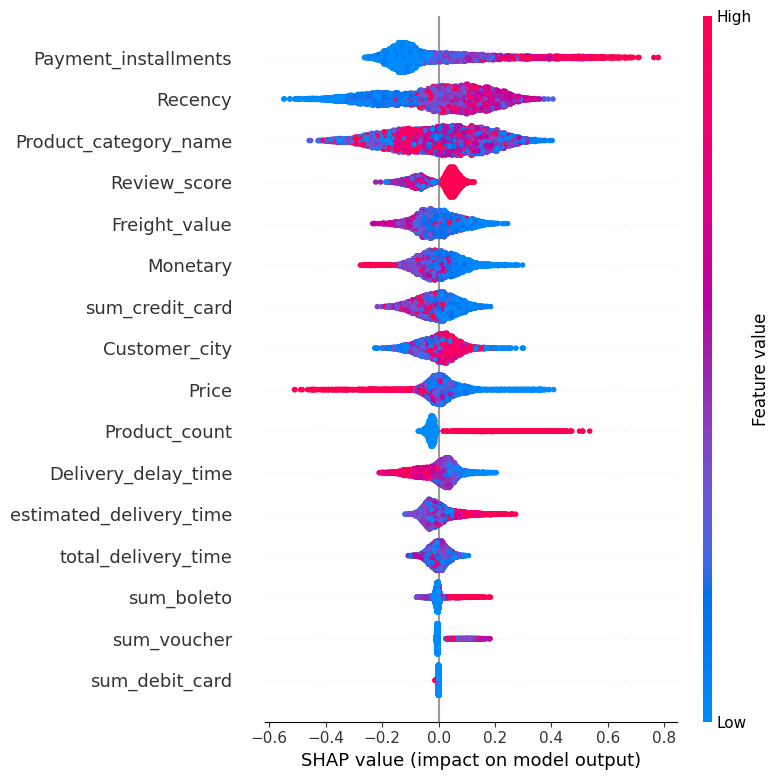

In [161]:
# SHAP 값
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
# y값 Purchases_count 1 : 2회이상 구매 고객, 0: 1회 구매 고객
# SHAP 요약 플롯
shap.summary_plot(shap_values, X_train)

### 로지스틱 회귀

In [164]:
# 로지스틱 회귀 모델 생성 및 훈련
log_model = LogisticRegression(random_state=42, max_iter=1000)


In [165]:
# 모델 훈련
log_model.fit(X_train, y_train)

# 예측
y_pred = log_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Accuracy: 0.5641

Confusion Matrix:
 [[927 669]
 [722 873]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.58      0.57      1596
           1       0.57      0.55      0.56      1595

    accuracy                           0.56      3191
   macro avg       0.56      0.56      0.56      3191
weighted avg       0.56      0.56      0.56      3191



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
